Notebook for matching the song lyrics with the topics of the Google Trends data.

# 0. Packages

In [55]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize  # For tokenizing
from nltk.stem import WordNetLemmatizer  # For lemmatizing
from nltk.corpus import stopwords  # Stopwords list
import re  # For regex expressions
from pandarallel import pandarallel  # For parallelizing pandas row operations
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from typing import Union  # Allows setting as inputs of a function a set of options
import matplotlib.pyplot as plt
from wordcloud import WordCloud  # To create word cloud

# Other utilities
import ast
from collections import Counter
from itertools import chain
import pickle
import os
import math

# 1. Importing the data

## 1.1. Songs data

In [56]:
# Songs dataset with lyrics
df = pd.read_csv(os.path.join('Spotify-Genius', 'billboard_hot_100_2004_2024_total.csv'))

df.head()

year  ranking               title                                artist  \
0  2004        1               Yeah!  Usher featuring Lil Jon and Ludacris   
1  2004        2                Burn                                 Usher   
2  2004        3  If I Ain't Got You                           Alicia Keys   
3  2004        4           This Love                              Maroon 5   
4  2004        5    The Way You Move        OutKast featuring Sleepy Brown   

                                              lyrics  \
0  [Intro: USHER & Lil Jon]\nPeace up, A-Town dow...   
1  [Intro]\nGirl, I understand why\nSee, it's bur...   
2  [Intro]\nMm-mm\nMm-mm, oh\nMm-mm\n[Verse 1]\nS...   
3  [Verse 1]\nI was so high I did not recognize\n...   
4  [Intro: Big Boi]\nBoom, boom, boom\nHa-ha!\n[V...   

                                            song_url  \
0               https://genius.com/usher-yeah-lyrics   
1               https://genius.com/usher-burn-lyrics   
2  https://genius.com/alicia-keys-if-i-aint-got-y...   
3       https://genius.com/maroon-5-this-love-lyrics   
4  https://genius.com/outkast-the-way-you-move-ly...   

                                 producers  \
0                              ['Lil Jon']   
1  ['Jermaine Dupri', 'Bryan-Michael Cox']   
2                          ['Alicia Keys']   
3          ['Mark Endert', 'Matt Wallace']   
4                   ['Big Boi', 'Carl Mo']   

                                             writers  \
0  ['Sean Garrett', 'Rob McDowell', 'Patrick “J. ...   
1   ['Jermaine Dupri', 'Bryan-Michael Cox', 'USHER']   
2                                    ['Alicia Keys']   
3                ['Jesse Carmichael', 'Adam Levine']   
4             ['Sleepy Brown', 'Big Boi', 'Carl Mo']   

                                  label         released_on  \
0  ['Arista Records', 'LaFace Records']    January 27, 2004   
1  ['LaFace Records', 'Arista Records']      March 21, 2004   
2                         ['J Records']   February 17, 2004   
3       ['J Records', 'Octone Records']       June 25, 2002   
4  ['Arista Records', 'LaFace Records']  September 23, 2003   

                                                tags  month  In English  Pop  \
0  ['Crunk', 'Pop Rap', 'Contemporary R&B', 'Dirt...      1           1    1   
1  ['Soul Pop', 'USA', 'Soul', 'Pop', 'R&B', 'In ...      3           1    1   
2  ['Ballad', 'R&B', 'In English', 'Soul Pop', 'U...      2           1    1   
3  ['Alternative R&B', 'Bubblegum Pop', 'Pop-Rock...      6           1    1   
4  ['Atlanta Rap', 'In English', 'Soul Pop', 'Sou...      9           1    0   

   Rap  R&B  Electro-Pop  Rock  usa year_month  
0    1    1            0     0    1    2004-01  
1    0    1            0     0    1    2004-03  
2    0    1            0     0    1    2004-02  
3    0    1            0     1    1    2004-06  
4    1    1            0     0    1    2004-09

In [57]:
# We drop the columns extended with the tags (we will create them later but for
# more tags), and also the extracted dates
df = df.drop(columns = df.columns[11:].to_list())
df.head()

year  ranking               title                                artist  \
0  2004        1               Yeah!  Usher featuring Lil Jon and Ludacris   
1  2004        2                Burn                                 Usher   
2  2004        3  If I Ain't Got You                           Alicia Keys   
3  2004        4           This Love                              Maroon 5   
4  2004        5    The Way You Move        OutKast featuring Sleepy Brown   

                                              lyrics  \
0  [Intro: USHER & Lil Jon]\nPeace up, A-Town dow...   
1  [Intro]\nGirl, I understand why\nSee, it's bur...   
2  [Intro]\nMm-mm\nMm-mm, oh\nMm-mm\n[Verse 1]\nS...   
3  [Verse 1]\nI was so high I did not recognize\n...   
4  [Intro: Big Boi]\nBoom, boom, boom\nHa-ha!\n[V...   

                                            song_url  \
0               https://genius.com/usher-yeah-lyrics   
1               https://genius.com/usher-burn-lyrics   
2  https://genius.com/alicia-keys-if-i-aint-got-y...   
3       https://genius.com/maroon-5-this-love-lyrics   
4  https://genius.com/outkast-the-way-you-move-ly...   

                                 producers  \
0                              ['Lil Jon']   
1  ['Jermaine Dupri', 'Bryan-Michael Cox']   
2                          ['Alicia Keys']   
3          ['Mark Endert', 'Matt Wallace']   
4                   ['Big Boi', 'Carl Mo']   

                                             writers  \
0  ['Sean Garrett', 'Rob McDowell', 'Patrick “J. ...   
1   ['Jermaine Dupri', 'Bryan-Michael Cox', 'USHER']   
2                                    ['Alicia Keys']   
3                ['Jesse Carmichael', 'Adam Levine']   
4             ['Sleepy Brown', 'Big Boi', 'Carl Mo']   

                                  label         released_on  \
0  ['Arista Records', 'LaFace Records']    January 27, 2004   
1  ['LaFace Records', 'Arista Records']      March 21, 2004   
2                         ['J Records']   February 17, 2004   
3       ['J Records', 'Octone Records']       June 25, 2002   
4  ['Arista Records', 'LaFace Records']  September 23, 2003   

                                                tags  
0  ['Crunk', 'Pop Rap', 'Contemporary R&B', 'Dirt...  
1  ['Soul Pop', 'USA', 'Soul', 'Pop', 'R&B', 'In ...  
2  ['Ballad', 'R&B', 'In English', 'Soul Pop', 'U...  
3  ['Alternative R&B', 'Bubblegum Pop', 'Pop-Rock...  
4  ['Atlanta Rap', 'In English', 'Soul Pop', 'Sou...

Below, we extract the year and the month of release from the `released_on` column (note that the year of release does not necessarily match the year when the song reached the Billboard top 100).

In [58]:
# Convert the column to datetime
df['released_on'] = pd.to_datetime(df['released_on'], format = 'mixed')

# Extract the year
df['release_year'] = df['released_on'].dt.year

# Extract the month
df['release_month'] = df['released_on'].dt.month

# Change the values in "year_month" to the release year and month (instead of
# Billboard year and month of release)
df['release_year_month'] = df['release_year'].astype(str) + '-' + df['release_month'].astype(str).str.zfill(2)

df.head()

year  ranking               title                                artist  \
0  2004        1               Yeah!  Usher featuring Lil Jon and Ludacris   
1  2004        2                Burn                                 Usher   
2  2004        3  If I Ain't Got You                           Alicia Keys   
3  2004        4           This Love                              Maroon 5   
4  2004        5    The Way You Move        OutKast featuring Sleepy Brown   

                                              lyrics  \
0  [Intro: USHER & Lil Jon]\nPeace up, A-Town dow...   
1  [Intro]\nGirl, I understand why\nSee, it's bur...   
2  [Intro]\nMm-mm\nMm-mm, oh\nMm-mm\n[Verse 1]\nS...   
3  [Verse 1]\nI was so high I did not recognize\n...   
4  [Intro: Big Boi]\nBoom, boom, boom\nHa-ha!\n[V...   

                                            song_url  \
0               https://genius.com/usher-yeah-lyrics   
1               https://genius.com/usher-burn-lyrics   
2  https://genius.com/alicia-keys-if-i-aint-got-y...   
3       https://genius.com/maroon-5-this-love-lyrics   
4  https://genius.com/outkast-the-way-you-move-ly...   

                                 producers  \
0                              ['Lil Jon']   
1  ['Jermaine Dupri', 'Bryan-Michael Cox']   
2                          ['Alicia Keys']   
3          ['Mark Endert', 'Matt Wallace']   
4                   ['Big Boi', 'Carl Mo']   

                                             writers  \
0  ['Sean Garrett', 'Rob McDowell', 'Patrick “J. ...   
1   ['Jermaine Dupri', 'Bryan-Michael Cox', 'USHER']   
2                                    ['Alicia Keys']   
3                ['Jesse Carmichael', 'Adam Levine']   
4             ['Sleepy Brown', 'Big Boi', 'Carl Mo']   

                                  label released_on  \
0  ['Arista Records', 'LaFace Records']  2004-01-27   
1  ['LaFace Records', 'Arista Records']  2004-03-21   
2                         ['J Records']  2004-02-17   
3       ['J Records', 'Octone Records']  2002-06-25   
4  ['Arista Records', 'LaFace Records']  2003-09-23   

                                                tags  release_year  \
0  ['Crunk', 'Pop Rap', 'Contemporary R&B', 'Dirt...          2004   
1  ['Soul Pop', 'USA', 'Soul', 'Pop', 'R&B', 'In ...          2004   
2  ['Ballad', 'R&B', 'In English', 'Soul Pop', 'U...          2004   
3  ['Alternative R&B', 'Bubblegum Pop', 'Pop-Rock...          2002   
4  ['Atlanta Rap', 'In English', 'Soul Pop', 'Sou...          2003   

   release_month release_year_month  
0              1            2004-01  
1              3            2004-03  
2              2            2004-02  
3              6            2002-06  
4              9            2003-09

Now, we extend the tags into dummies for several columns.

In [59]:
# Reconvert format of tags
df["tags"] = df["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Get the unique tags
all_tags = set(tag for tags in df['tags'] for tag in tags)
print(f'Number of unique tags: {len(all_tags)}')

Number of unique tags: 427


In [60]:
# Flatten all tags and count occurrences
tag_counts = Counter(tag for tags in df['tags'] for tag in tags)

# Select the top x most common tags (e.g., top 10)
x = 20
top_x_tags = {tag for tag, _ in tag_counts.most_common(x)}

# Print the top tags
print(f'Top {x} tags: {top_x_tags}')

Top 20 tags: {'Contemporary R&B', 'Ballad', 'Pop Rap', 'Country', 'Rock', 'Alternative Pop', 'Dance-Pop', 'Electronic', 'Adult Contemporary', 'Rap', 'Trap', 'Electro-Pop', 'Dance', 'Hip-Hop', 'Pop-Rock', 'R&B', 'In English', 'Pop', 'USA', 'Alternative'}


In [61]:
# Create dummy columns for the top x tags
for tag in top_x_tags:
    df[f'{tag}'] = df['tags'].apply(lambda tags: int(tag in tags))

# Display the dataframe with the new dummy columns
df.head()

year  ranking               title                                artist  \
0  2004        1               Yeah!  Usher featuring Lil Jon and Ludacris   
1  2004        2                Burn                                 Usher   
2  2004        3  If I Ain't Got You                           Alicia Keys   
3  2004        4           This Love                              Maroon 5   
4  2004        5    The Way You Move        OutKast featuring Sleepy Brown   

                                              lyrics  \
0  [Intro: USHER & Lil Jon]\nPeace up, A-Town dow...   
1  [Intro]\nGirl, I understand why\nSee, it's bur...   
2  [Intro]\nMm-mm\nMm-mm, oh\nMm-mm\n[Verse 1]\nS...   
3  [Verse 1]\nI was so high I did not recognize\n...   
4  [Intro: Big Boi]\nBoom, boom, boom\nHa-ha!\n[V...   

                                            song_url  \
0               https://genius.com/usher-yeah-lyrics   
1               https://genius.com/usher-burn-lyrics   
2  https://genius.com/alicia-keys-if-i-aint-got-y...   
3       https://genius.com/maroon-5-this-love-lyrics   
4  https://genius.com/outkast-the-way-you-move-ly...   

                                 producers  \
0                              ['Lil Jon']   
1  ['Jermaine Dupri', 'Bryan-Michael Cox']   
2                          ['Alicia Keys']   
3          ['Mark Endert', 'Matt Wallace']   
4                   ['Big Boi', 'Carl Mo']   

                                             writers  \
0  ['Sean Garrett', 'Rob McDowell', 'Patrick “J. ...   
1   ['Jermaine Dupri', 'Bryan-Michael Cox', 'USHER']   
2                                    ['Alicia Keys']   
3                ['Jesse Carmichael', 'Adam Levine']   
4             ['Sleepy Brown', 'Big Boi', 'Carl Mo']   

                                  label released_on  ... Trap  Electro-Pop  \
0  ['Arista Records', 'LaFace Records']  2004-01-27  ...    0            0   
1  ['LaFace Records', 'Arista Records']  2004-03-21  ...    0            0   
2                         ['J Records']  2004-02-17  ...    0            0   
3       ['J Records', 'Octone Records']  2002-06-25  ...    0            0   
4  ['Arista Records', 'LaFace Records']  2003-09-23  ...    0            0   

   Dance Hip-Hop  Pop-Rock  R&B  In English  Pop  USA  Alternative  
0      0       1         0    1           1    1    1            0  
1      0       0         0    1           1    1    1            0  
2      0       0         0    1           1    1    1            0  
3      1       0         1    1           1    1    1            1  
4      0       0         0    1           1    0    1            0  

[5 rows x 34 columns]

However, note that not necessarily all of the songs have the correct tags associated to it (e.g., for the tag "In English" there are several songs with 0s on it which are actually in English).

Finally, below we drop all of the songs that were released before the year 2003 (since Google Trends data goes back to 2004-01, and we want to keep a lag of 1 year in case we use it).

In [62]:
df = df[df['release_year'] >= 2003].reset_index(drop = True)

df.head()

year  ranking               title                                artist  \
0  2004        1               Yeah!  Usher featuring Lil Jon and Ludacris   
1  2004        2                Burn                                 Usher   
2  2004        3  If I Ain't Got You                           Alicia Keys   
3  2004        5    The Way You Move        OutKast featuring Sleepy Brown   
4  2004        6          The Reason                            Hoobastank   

                                              lyrics  \
0  [Intro: USHER & Lil Jon]\nPeace up, A-Town dow...   
1  [Intro]\nGirl, I understand why\nSee, it's bur...   
2  [Intro]\nMm-mm\nMm-mm, oh\nMm-mm\n[Verse 1]\nS...   
3  [Intro: Big Boi]\nBoom, boom, boom\nHa-ha!\n[V...   
4  [Verse 1]\nI'm not a perfect person\nThere's m...   

                                            song_url  \
0               https://genius.com/usher-yeah-lyrics   
1               https://genius.com/usher-burn-lyrics   
2  https://genius.com/alicia-keys-if-i-aint-got-y...   
3  https://genius.com/outkast-the-way-you-move-ly...   
4    https://genius.com/hoobastank-the-reason-lyrics   

                                 producers  \
0                              ['Lil Jon']   
1  ['Jermaine Dupri', 'Bryan-Michael Cox']   
2                          ['Alicia Keys']   
3                   ['Big Boi', 'Carl Mo']   
4                        ['Howard Benson']   

                                             writers  \
0  ['Sean Garrett', 'Rob McDowell', 'Patrick “J. ...   
1   ['Jermaine Dupri', 'Bryan-Michael Cox', 'USHER']   
2                                    ['Alicia Keys']   
3             ['Sleepy Brown', 'Big Boi', 'Carl Mo']   
4                     ['Dan Estrin', 'Douglas Robb']   

                                      label released_on  ... Trap  \
0      ['Arista Records', 'LaFace Records']  2004-01-27  ...    0   
1      ['LaFace Records', 'Arista Records']  2004-03-21  ...    0   
2                             ['J Records']  2004-02-17  ...    0   
3      ['Arista Records', 'LaFace Records']  2003-09-23  ...    0   
4  ['Def Jam Recordings', 'Island Records']  2003-12-09  ...    0   

   Electro-Pop  Dance Hip-Hop  Pop-Rock  R&B  In English  Pop  USA  \
0            0      0       1         0    1           1    1    1   
1            0      0       0         0    1           1    1    1   
2            0      0       0         0    1           1    1    1   
3            0      0       0         0    1           1    0    1   
4            0      0       0         0    0           1    0    1   

   Alternative  
0            0  
1            0  
2            0  
3            0  
4            0  

[5 rows x 34 columns]

We also keep another data frame only with songs tagged as "USA". 

In [63]:
df_usa = df[df['USA'] == 1]

## 1.2. Google Trends data

In [64]:
df_gt = pd.read_csv(os.path.join('google_trends', 'multiTimeline.csv'), skiprows = 2)

df_gt = df_gt.rename(columns = {'health: (United States)': 'health',
                                'money: (United States)': 'money',
                                'justice: (United States)': 'justice',
                                'police: (United States)': 'police',
                                'politics: (United States)': 'politics'})

df_gt.head()

Month  health  money  justice  police  politics
0  2004-01      82     30       10      31         4
1  2004-02      80     29       11      28         5
2  2004-03      79     30       10      30         5
3  2004-04      79     30       11      29         5
4  2004-05      74     28        9      29         4

In [65]:
# Ensure 'Month' is a datetime column
df_gt['Month'] = pd.to_datetime(df_gt['Month'])

We have Google Trends data on the interest on 5 different topics:
1. Health.
2. Money.
3. Justice.
4. Police.
5. Politics.

## 1.3. ConceptNet dictionaries

In [66]:
df_cnet = pd.read_csv(os.path.join('ConceptNet', 'concept_net_terms.csv'))

df_cnet.head()

label  num_words language  weight type_relation   term_conceptnet  \
0      agency          1       en     2.0       Synonym      /c/en/agency   
1     control          1       en     2.0           IsA     /c/en/control   
2      expert          1       en     2.0           IsA      /c/en/expert   
3  permission          1       en     2.0           IsA  /c/en/permission   
4      person          1       en     2.0           IsA      /c/en/person   

  input_term  
0  authority  
1  authority  
2  authority  
3  authority  
4  authority

In [67]:
# Unique topics for which we have associated terms
print(df_cnet['input_term'].unique())

['authority' 'country' 'health' 'justice' 'money' 'parliament' 'police'
 'politics' 'united_states']


In [68]:
# We only keep the topics for which we have Google Trends data
df_cnet = df_cnet[df_cnet['input_term'].isin(['health', 'money', 'justice', 'police', 'politics'])].reset_index(drop = True)

df_cnet.head()

label  num_words language    weight type_relation  term_conceptnet  \
0      being          1       en  2.474672     RelatedTo      /c/en/being   
1       well          1       en  2.442949     RelatedTo       /c/en/well   
2  wellbeing          1       en  2.000000           IsA  /c/en/wellbeing   
3  condition          1       en  2.000000           IsA  /c/en/condition   
4       good          1       en  1.983000     RelatedTo       /c/en/good   

  input_term  
0     health  
1     health  
2     health  
3     health  
4     health

Now, we will normalize the weights to the scale of 1-9 (10 is saved for the input term of each topic). The weights will be normalized within each input term, so that each topic is given the same prior relevance.

In [69]:
# Normalize the weights to the scale of 1-9, grouped by each input term
df_cnet['weight_normalized'] = df_cnet.groupby('input_term')['weight'].transform(
    lambda x: 1 + 8 * (x - x.min()) / (x.max() - x.min())
)

df_cnet['weight_normalized'].describe()

count    189.000000
mean       3.387439
std        2.496843
min        1.000000
25%        1.000000
50%        2.821834
75%        4.719636
max        9.000000
Name: weight_normalized, dtype: float64

In [70]:
df_cnet.head()

label  num_words language    weight type_relation  term_conceptnet  \
0      being          1       en  2.474672     RelatedTo      /c/en/being   
1       well          1       en  2.442949     RelatedTo       /c/en/well   
2  wellbeing          1       en  2.000000           IsA  /c/en/wellbeing   
3  condition          1       en  2.000000           IsA  /c/en/condition   
4       good          1       en  1.983000     RelatedTo       /c/en/good   

  input_term  weight_normalized  
0     health           9.000000  
1     health           8.892176  
2     health           7.386617  
3     health           7.386617  
4     health           7.328835

In [71]:
# Manually concatenate the terms for each input term
df_cnet_input = pd.DataFrame({
    'label': ['health', 'money', 'justice', 'police', 'politics'],
    'num_words': [1, 1, 1, 1, 1],
    'language': ['en', 'en', 'en', 'en', 'en'],
    'weight': [np.nan, np.nan, np.nan, np.nan, np.nan],
    'type_relation': [np.nan, np.nan, np.nan, np.nan, np.nan],
    'term_conceptnet': ['/c/en/health', '/c/en/money', '/c/en/justice', '/c/en/police', '/c/en/politics'],
    'input_term': ['health', 'money', 'justice', 'police', 'politics'],
    'weight_normalized': [10, 10, 10, 10, 10]
})

df_cnet = pd.concat([df_cnet, df_cnet_input], ignore_index = True)

df_cnet.head()

label  num_words language    weight type_relation  term_conceptnet  \
0      being          1       en  2.474672     RelatedTo      /c/en/being   
1       well          1       en  2.442949     RelatedTo       /c/en/well   
2  wellbeing          1       en  2.000000           IsA  /c/en/wellbeing   
3  condition          1       en  2.000000           IsA  /c/en/condition   
4       good          1       en  1.983000     RelatedTo       /c/en/good   

  input_term  weight_normalized  
0     health           9.000000  
1     health           8.892176  
2     health           7.386617  
3     health           7.386617  
4     health           7.328835

In [72]:
# Remove unnecessary data frame
del df_cnet_input

# 2. Text preprocessing

In [73]:
# Initialize parallelization for pandas
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## 2.1. Tokenizing and stopword removal

Below, we tokenize the text and lowercase it, both for the songs data and the ConceptNet dictionary of terms.

In [74]:
def preprocess_lower(text, rm_stopwords = False, stopword_set = None):
    """
    Preprocess text by:
       - Converting to lowercase.
       - Removing punctuation and digits.
       - Tokenizing.
       - Removing stopwords (optional).
    
    Returns:
        list: A list of tokens lowercased and without punctuation.
    """
    text_lower = text.lower()
    text_no_punct = re.sub(r'[^a-zA-Z\s]', ' ', text_lower)  # Remove digits and punctuation, replace by whitespace
    tokens = word_tokenize(text_no_punct)
    tokens = word_tokenize(text_no_punct)
    # Remove stopwords if desired
    if rm_stopwords == True:
        tokens = [token for token in tokens if token not in stopword_set]
    # We return the whole string of tokens so that we can find n-grams later
    return " ".join(tokens)

In [75]:
my_stop_words = set(stopwords.words('english'))

# Create set of custom stopwords (optional)
my_custom_stopwords = {'intro', 'verse', 'chorus', 'bridge'} 

# Update stopwords (optional)
my_stop_words.update(my_custom_stopwords)

In [76]:
df['lyrics_lower'] = df['lyrics'].parallel_apply(
    lambda row: preprocess_lower(text = row, rm_stopwords=True, stopword_set=my_stop_words)
    )

In [77]:
df.head()

year  ranking               title                                artist  \
0  2004        1               Yeah!  Usher featuring Lil Jon and Ludacris   
1  2004        2                Burn                                 Usher   
2  2004        3  If I Ain't Got You                           Alicia Keys   
3  2004        5    The Way You Move        OutKast featuring Sleepy Brown   
4  2004        6          The Reason                            Hoobastank   

                                              lyrics  \
0  [Intro: USHER & Lil Jon]\nPeace up, A-Town dow...   
1  [Intro]\nGirl, I understand why\nSee, it's bur...   
2  [Intro]\nMm-mm\nMm-mm, oh\nMm-mm\n[Verse 1]\nS...   
3  [Intro: Big Boi]\nBoom, boom, boom\nHa-ha!\n[V...   
4  [Verse 1]\nI'm not a perfect person\nThere's m...   

                                            song_url  \
0               https://genius.com/usher-yeah-lyrics   
1               https://genius.com/usher-burn-lyrics   
2  https://genius.com/alicia-keys-if-i-aint-got-y...   
3  https://genius.com/outkast-the-way-you-move-ly...   
4    https://genius.com/hoobastank-the-reason-lyrics   

                                 producers  \
0                              ['Lil Jon']   
1  ['Jermaine Dupri', 'Bryan-Michael Cox']   
2                          ['Alicia Keys']   
3                   ['Big Boi', 'Carl Mo']   
4                        ['Howard Benson']   

                                             writers  \
0  ['Sean Garrett', 'Rob McDowell', 'Patrick “J. ...   
1   ['Jermaine Dupri', 'Bryan-Michael Cox', 'USHER']   
2                                    ['Alicia Keys']   
3             ['Sleepy Brown', 'Big Boi', 'Carl Mo']   
4                     ['Dan Estrin', 'Douglas Robb']   

                                      label released_on  ... Electro-Pop  \
0      ['Arista Records', 'LaFace Records']  2004-01-27  ...           0   
1      ['LaFace Records', 'Arista Records']  2004-03-21  ...           0   
2                             ['J Records']  2004-02-17  ...           0   
3      ['Arista Records', 'LaFace Records']  2003-09-23  ...           0   
4  ['Def Jam Recordings', 'Island Records']  2003-12-09  ...           0   

   Dance  Hip-Hop Pop-Rock  R&B  In English  Pop  USA  Alternative  \
0      0        1        0    1           1    1    1            0   
1      0        0        0    1           1    1    1            0   
2      0        0        0    1           1    1    1            0   
3      0        0        0    1           1    0    1            0   
4      0        0        0    0           1    0    1            0   

                                        lyrics_lower  
0  usher lil jon peace town yeah yeah okay okay u...  
1  girl understand see burnin hold know somethin ...  
2  mm mm mm mm oh mm mm people live fortune peopl...  
3  big boi boom boom boom ha ha big boi ready act...  
4  perfect person many things wish continue learn...  

[5 rows x 35 columns]

In [78]:
# Apply the same preprocessing to the ConceptNet labels
df_cnet['label_lower'] = df_cnet['label'].parallel_apply(
    lambda row: preprocess_lower(text = row, rm_stopwords=True, stopword_set=my_stop_words)
    )

In [79]:
df_cnet.head()

label  num_words language    weight type_relation  term_conceptnet  \
0      being          1       en  2.474672     RelatedTo      /c/en/being   
1       well          1       en  2.442949     RelatedTo       /c/en/well   
2  wellbeing          1       en  2.000000           IsA  /c/en/wellbeing   
3  condition          1       en  2.000000           IsA  /c/en/condition   
4       good          1       en  1.983000     RelatedTo       /c/en/good   

  input_term  weight_normalized label_lower  
0     health           9.000000              
1     health           8.892176        well  
2     health           7.386617   wellbeing  
3     health           7.386617   condition  
4     health           7.328835        good

Notice, however, that there are some labels that have completely disappeared (as they were just stopwords). For simplicity, we should remove these labels from the ConceptNet dictionary.

In [80]:
df_cnet = df_cnet[df_cnet['label_lower'] != '']

df_cnet.head()

label  num_words language    weight type_relation   term_conceptnet  \
1        well          1       en  2.442949     RelatedTo        /c/en/well   
2   wellbeing          1       en  2.000000           IsA   /c/en/wellbeing   
3   condition          1       en  2.000000           IsA   /c/en/condition   
4        good          1       en  1.983000     RelatedTo        /c/en/good   
5  well being          2       en  1.829000     RelatedTo  /c/en/well_being   

  input_term  weight_normalized label_lower  
1     health           8.892176        well  
2     health           7.386617   wellbeing  
3     health           7.386617   condition  
4     health           7.328835        good  
5     health           6.805398        well

## 2.2. Normalization: lemmatizing

Below, we stick to lemmatizing as it is the normalization option that we think provides with the best results in this case.

In [81]:
def preprocess_lemmatize(text):
    """
    Preprocess text by applying lemmatized.
    Should just input a string which has been previously pre-processed, which at least removes
    the punctuation.

    Returns:
        str: A string of lemmatized tokens separated by spaces.
    """

    tokens = text.split()  # Split input text based on whitespaces
    lemmatizer = WordNetLemmatizer()  # Initiallize lemmatizer
    lemmatized_text = []  # Initialize empty list to store lemmatized text
    for word in tokens:
        lemmatized_text.append(lemmatizer.lemmatize(word))

    return " ".join(lemmatized_text)

Lemmatizing with `Spacy` instead of with `WordNetLemmatizer` of `nltk` leads to similar results. In general, however, it seems that there are no significant changes after lemmatizing the text.

In [82]:
df['lyrics_lemmatized'] = df['lyrics_lower'].parallel_apply(
    lambda row: preprocess_lemmatize(text = row)
    )

In [83]:
df.head()

year  ranking               title                                artist  \
0  2004        1               Yeah!  Usher featuring Lil Jon and Ludacris   
1  2004        2                Burn                                 Usher   
2  2004        3  If I Ain't Got You                           Alicia Keys   
3  2004        5    The Way You Move        OutKast featuring Sleepy Brown   
4  2004        6          The Reason                            Hoobastank   

                                              lyrics  \
0  [Intro: USHER & Lil Jon]\nPeace up, A-Town dow...   
1  [Intro]\nGirl, I understand why\nSee, it's bur...   
2  [Intro]\nMm-mm\nMm-mm, oh\nMm-mm\n[Verse 1]\nS...   
3  [Intro: Big Boi]\nBoom, boom, boom\nHa-ha!\n[V...   
4  [Verse 1]\nI'm not a perfect person\nThere's m...   

                                            song_url  \
0               https://genius.com/usher-yeah-lyrics   
1               https://genius.com/usher-burn-lyrics   
2  https://genius.com/alicia-keys-if-i-aint-got-y...   
3  https://genius.com/outkast-the-way-you-move-ly...   
4    https://genius.com/hoobastank-the-reason-lyrics   

                                 producers  \
0                              ['Lil Jon']   
1  ['Jermaine Dupri', 'Bryan-Michael Cox']   
2                          ['Alicia Keys']   
3                   ['Big Boi', 'Carl Mo']   
4                        ['Howard Benson']   

                                             writers  \
0  ['Sean Garrett', 'Rob McDowell', 'Patrick “J. ...   
1   ['Jermaine Dupri', 'Bryan-Michael Cox', 'USHER']   
2                                    ['Alicia Keys']   
3             ['Sleepy Brown', 'Big Boi', 'Carl Mo']   
4                     ['Dan Estrin', 'Douglas Robb']   

                                      label released_on  ... Dance  Hip-Hop  \
0      ['Arista Records', 'LaFace Records']  2004-01-27  ...     0        1   
1      ['LaFace Records', 'Arista Records']  2004-03-21  ...     0        0   
2                             ['J Records']  2004-02-17  ...     0        0   
3      ['Arista Records', 'LaFace Records']  2003-09-23  ...     0        0   
4  ['Def Jam Recordings', 'Island Records']  2003-12-09  ...     0        0   

   Pop-Rock R&B  In English  Pop  USA  Alternative  \
0         0   1           1    1    1            0   
1         0   1           1    1    1            0   
2         0   1           1    1    1            0   
3         0   1           1    0    1            0   
4         0   0           1    0    1            0   

                                        lyrics_lower  \
0  usher lil jon peace town yeah yeah okay okay u...   
1  girl understand see burnin hold know somethin ...   
2  mm mm mm mm oh mm mm people live fortune peopl...   
3  big boi boom boom boom ha ha big boi ready act...   
4  perfect person many things wish continue learn...   

                                   lyrics_lemmatized  
0  usher lil jon peace town yeah yeah okay okay u...  
1  girl understand see burnin hold know somethin ...  
2  mm mm mm mm oh mm mm people live fortune peopl...  
3  big boi boom boom boom ha ha big boi ready act...  
4  perfect person many thing wish continue learni...  

[5 rows x 36 columns]

In [84]:
df_cnet['label_lemmatized'] = df_cnet['label_lower'].parallel_apply(
    lambda row: preprocess_lemmatize(text = row)
    )

In [85]:
df_cnet.head()

label  num_words language    weight type_relation   term_conceptnet  \
1        well          1       en  2.442949     RelatedTo        /c/en/well   
2   wellbeing          1       en  2.000000           IsA   /c/en/wellbeing   
3   condition          1       en  2.000000           IsA   /c/en/condition   
4        good          1       en  1.983000     RelatedTo        /c/en/good   
5  well being          2       en  1.829000     RelatedTo  /c/en/well_being   

  input_term  weight_normalized label_lower label_lemmatized  
1     health           8.892176        well             well  
2     health           7.386617   wellbeing        wellbeing  
3     health           7.386617   condition        condition  
4     health           7.328835        good             good  
5     health           6.805398        well             well

In [86]:
# Print sample text
songs_index = 8
print('Original text: \n', df['lyrics'][songs_index])

Original text: 
 [Intro: Fat Joe]
Owwwwww! Yeah! My niggas, ahah
Throw your hands in the air right now, man!
Feel this shit right here,
Scott Storch, nigga
Yeah Khaled, I see you nigga
,
ShowBiz, Born Lord
Uh, yeah, uh, yo
[Verse 1: Fat Joe]
I don't give a fuck about your faults or mishappens
Nigga, we from the Bronx, New York, shit happens
Kids clappin', love to spark the place
Half the niggas in the Squad got a scar on their face
It's a cold world and this is ice
Half a mil' for the charm, nigga, this is life
Got the Phantom in front of the building, Trinity Ave
Ten years been legit, they still figure me bad
As a youngin, was too much to cope with
Why you think, muh'fuckers nicknamed me Cook Coke shit?
Should've been called Armed Robbery
Extortion, or maybe Grand Larceny
I did it all
, I put the pieces to the puzzle
Just as long, I knew me and my peoples was gon' bubble
Came out the gate on some Flo-Jo shit
Fat nigga with the shotty was the logo, kid
[Chorus: Fat Joe]
I said my nigga

In [87]:
print('Lowercased text, without stopwords: \n', df['lyrics_lower'][songs_index])

Lowercased text, without stopwords: 
 fat joe owwwwww yeah niggas ahah throw hands air right man feel shit right scott storch nigga yeah khaled see nigga showbiz born lord uh yeah uh yo fat joe give fuck faults mishappens nigga bronx new york shit happens kids clappin love spark place half niggas squad got scar face cold world ice half mil charm nigga life got phantom front building trinity ave ten years legit still figure bad youngin much cope think muh fuckers nicknamed cook coke shit called armed robbery extortion maybe grand larceny put pieces puzzle long knew peoples gon bubble came gate flo jo shit fat nigga shotty logo kid fat joe said niggas dance pull pants rockaway lean back lean back lean back lean back come said niggas dance pull pants rockaway lean back lean back lean back lean back come


In [88]:
print('Lemmatized text: \n', df['lyrics_lemmatized'][songs_index])

Lemmatized text: 
 fat joe owwwwww yeah nigga ahah throw hand air right man feel shit right scott storch nigga yeah khaled see nigga showbiz born lord uh yeah uh yo fat joe give fuck fault mishappens nigga bronx new york shit happens kid clappin love spark place half nigga squad got scar face cold world ice half mil charm nigga life got phantom front building trinity ave ten year legit still figure bad youngin much cope think muh fucker nicknamed cook coke shit called armed robbery extortion maybe grand larceny put piece puzzle long knew people gon bubble came gate flo jo shit fat nigga shotty logo kid fat joe said nigga dance pull pant rockaway lean back lean back lean back lean back come said nigga dance pull pant rockaway lean back lean back lean back lean back come


## 2.3. Vectorizing - *tf-idf*

In this step, we just vectorize the already-preprocessed text (though we could remove stopwords with the parameters `stop_words`, lowercase the text with `lowercase`, etc.). For more information, check: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

- **`fit()`** learns the vocabulary from all text in the Series.
- **`transform()`** converts each row into a numerical representation based on that vocabulary.
- The output is a **sparse matrix**, which can be converted to dense with `.todense()`.
- **`vectorized_text.shape`** gives the size of the document-term matrix:  
  - Rows = number of documents (i.e., number of books)  
  - Columns = number of unique words in the vocabulary  
- **`cv.get_feature_names_out()`** returns the list of terms that were extracted.

### Applying *tf-idf*

In [89]:
def vectorizer(cv: Union[CountVectorizer, TfidfVectorizer], df: pd.DataFrame, column_text: str) -> pd.DataFrame:

    # Note that we can fit the count vectorizer with a pandas series
    cv.fit(df[column_text])
    dtm = cv.transform(df[column_text])  # Create DTM

    # Return dense interpretation of sparse matrix
    dtm_dense = dtm.todense()

    # Print DTM size
    print("Document-term matrix has size", dtm_dense.shape)

    # Save extracted terms
    terms = cv.get_feature_names_out()

    return dtm_dense, terms

According to the notebooks `session4_vectormath` and the one of the 3rd TA session (`vectorization_students_2025`), the way we can replicate the *tf-idf* function seen in class is by setting the following parameters: 

- Setting the smoothing parameter to `True` may be useful for preventing zero values whenever there is a term that is included in the matrix but that isn't seen in any document.
- On the other hand, setting the parameter `sublinear_tf=True` is essential to replicate the idea of the regular tf-idf seen in class.

For more information, check https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html. 

In [90]:
# Step 1: initialize the tfidf vectorizer
tfidf = TfidfVectorizer(
    lowercase=False,
    stop_words=None,
    sublinear_tf=True,  # Apply tf-idf seen in class 
    smooth_idf=False, 
    ngram_range=(1,3),  # Include unigrams, bigrams and trigrams (as ConcepNet terms include all 3)
    min_df=0.001,  # Ignore terms appearing in less than 0.1% of the documents (2 songs with 2000 songs)
    max_df=0.6,  # Ignore terms appearing in more than 60% of the documents 
    )

# Step 2: execute the function
dtm_lemmatized, terms_lemmatized = vectorizer(
    cv = tfidf, df = df, column_text='lyrics_lemmatized'
    )

Document-term matrix has size (2067, 14006)


Keeping a `min_df` in the function above is feasible for this dataset, given that the text of each document (the song lyrics) is short.

In [91]:
# We create a data frame from the dense document-term matrix, with columns named
# as the extracted terms
dtm_df = pd.DataFrame(dtm_lemmatized, columns=terms_lemmatized)

dtm_df.head()

ab  able  abused   ac  accent  account  ace  ache  aching  acrobat  ...  \
0  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   
1  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   
2  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   
3  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   
4  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   

   yung joc  yup  yuu  zach  zayn  zero  zero got  zip  zombie  zone  
0       0.0  0.0  0.0   0.0   0.0   0.0       0.0  0.0     0.0   0.0  
1       0.0  0.0  0.0   0.0   0.0   0.0       0.0  0.0     0.0   0.0  
2       0.0  0.0  0.0   0.0   0.0   0.0       0.0  0.0     0.0   0.0  
3       0.0  0.0  0.0   0.0   0.0   0.0       0.0  0.0     0.0   0.0  
4       0.0  0.0  0.0   0.0   0.0   0.0       0.0  0.0     0.0   0.0  

[5 rows x 14006 columns]

In [92]:
dtm_df.shape

(2067, 14006)

# 3. Loading of topics per song with ConceptNet

### Loading per song (document)

Now, the idea is to compute the loading of each topic per song using the DTM and the ConceptNet preprocessed data frame (specifically, the lemmatized labels, the normalized weights and the topic associated to each term). To do that, we will:
1) Match each of the terms in the DTM with the terms for each topic considered with ConceptNet.
2) Sum the product of the ConceptNet terms with the matched terms' *tf-idf* weights in the songs DTM.
3) Divide the previous operation by the sum of all of the *tf-idf* weights for each document. This normalizes the result of the weighted sums to [0, 1], with 1 being a document with full loading for a certain topic and 0 the document with the lowest loading for a certain topic.

*Note*: for concatenating the results with the metadata below, **we will not alter the order of the DTM or of the songs data frame**. Note that the document-term matrix produced by scikit‐learn’s vectorizer preserves the order of the input documents (i.e. the order of rows in the DTM corresponds to the order in the original data frame). This characteristic is considered below to append the metadata to the DTM. 

In [93]:
# Create a dictionary to store both terms and weights for each topic
topic_data = {}

# Get unique terms and weights for each topic
for topic in df_cnet['input_term'].unique():
    
    # Topic name
    topic_name = f'{topic.lower()}'
    
    # Get the subset of data for this topic
    topic_df = df_cnet[df_cnet['input_term'] == topic]
    
    # Extract the lemmatized terms for this topic
    terms = topic_df['label_lemmatized'].to_list()
    
    # Extract the corresponding weights
    weights = topic_df['weight_normalized'].to_list()
    
    # Create nested dictionary with terms and weights lists
    topic_data[f"{topic_name}"] = {
        "terms": terms,
        "normalized_weights": weights
    }

print(topic_data)

{'health': {'terms': ['well', 'wellbeing', 'condition', 'good', 'well', 'body', 'healthiness', 'sanidad', 'heartiness', 'malfunction', 'toast', 'everyone', 'function', 'mental', 'video game', 'prosperity', 'organism', 'physical', 'whole', 'heal', 'salud', 'social', 'illness', 'state', 'disease', 'sickness', 'robustness', 'important', 'psychological', 'wellness', 'balance', 'sick', 'medical', 'feeling good', 'feeling', 'fitness', 'well', 'status', 'health', 'ill', 'fat', 'sickly', 'death', 'health'], 'normalized_weights': [8.892176439312824, 7.38661714350238, 7.38661714350238, 7.328835083130087, 6.805397595051658, 6.11201287058413, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3.9876724157203793, 3

In [94]:
# Create a DataFrame to store the results, with the same index as the DTM data frame
result_df = pd.DataFrame(index=dtm_df.index)

# Calculate the sum of all tf-idf weights for each document (row)
document_total_weights = dtm_df.sum(axis=1)

# Process each topic
for topic_key, topic_content in topic_data.items():

    topic_name = topic_key  # Extract just the topic name
    
    # Initialize an array to store the weighted sum for each document
    weighted_sums = np.zeros(len(dtm_df))
    
    # Get terms and weights for this topic
    topic_terms = topic_content['terms']
    topic_weights = topic_content['normalized_weights']
    
    # Create a dictionary mapping terms to their weights for faster lookup
    term_to_weight = dict(zip(topic_terms, topic_weights))
    
    # For each term in the topic
    for term, weight in term_to_weight.items():
        # Check if the term exists in the DTM columns
        if term in dtm_df.columns:
            # Multiply the term's tf-idf value by the term's weight and add to the sum
            weighted_sums += dtm_df[term].values * weight
    
    # Add the weighted sums as a new column in the result DataFrame
    # result_df[f'weighted_sum_{topic_name}'] = weighted_sums

    # Add the normalized weighted sums (relative relevance)
    result_df[f'relative_relevance_{topic_name}'] = weighted_sums / document_total_weights.values

Now, `results_df` contains a column for each topic with the relative relevance of topics for each document, computed as the weighted sum of *tf-idf* weights for a document on a certain topic divided by the total sum of *tf-idf* weights for a certain document. Therefore, the result is normalized to 1 and gives something similar to the "loading" of certain topics for each document.

In [95]:
result_df.head()

relative_relevance_health  relative_relevance_justice  \
0                   0.000000                    0.000000   
1                   0.029409                    0.000000   
2                   0.098985                    0.180572   
3                   0.000000                    0.000000   
4                   0.000000                    0.000000   

   relative_relevance_money  relative_relevance_police  \
0                  0.000000                    0.00000   
1                  0.000000                    0.00000   
2                  0.000000                    0.03826   
3                  0.012878                    0.00000   
4                  0.000000                    0.00000   

   relative_relevance_politics  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          0.0

In [96]:
# Concatenate the data frames along the columns (to do this, ensure that the indexes
# are aligned for both data frames)
dtm_df_ext = pd.concat([dtm_df, result_df], axis=1)

dtm_df_ext.head()

ab  able  abused   ac  accent  account  ace  ache  aching  acrobat  ...  \
0  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   
1  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   
2  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   
3  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   
4  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   

   zero  zero got  zip  zombie  zone  relative_relevance_health  \
0   0.0       0.0  0.0     0.0   0.0                   0.000000   
1   0.0       0.0  0.0     0.0   0.0                   0.029409   
2   0.0       0.0  0.0     0.0   0.0                   0.098985   
3   0.0       0.0  0.0     0.0   0.0                   0.000000   
4   0.0       0.0  0.0     0.0   0.0                   0.000000   

   relative_relevance_justice  relative_relevance_money  \
0                    0.000000                  0.000000   
1                    0.000000                  0.000000   
2                    0.180572                  0.000000   
3                    0.000000                  0.012878   
4                    0.000000                  0.000000   

   relative_relevance_police  relative_relevance_politics  
0                    0.00000                          0.0  
1                    0.00000                          0.0  
2                    0.03826                          0.0  
3                    0.00000                          0.0  
4                    0.00000                          0.0  

[5 rows x 14011 columns]

In [97]:
print(dtm_df_ext.shape)

(2067, 14011)


In [98]:
null_summary = dtm_df_ext.isnull().sum()
null_summary = null_summary[null_summary > 0]  # Filter only columns with nulls
print(null_summary)

Series([], dtype: int64)


### Concatenating the result of the loadings with metadata

In [99]:
# Columns from the original data frame
print(df.columns)

Index(['year', 'ranking', 'title', 'artist', 'lyrics', 'song_url', 'producers',
       'writers', 'label', 'released_on', 'tags', 'release_year',
       'release_month', 'release_year_month', 'Contemporary R&B', 'Ballad',
       'Pop Rap', 'Country', 'Rock', 'Alternative Pop', 'Dance-Pop',
       'Electronic', 'Adult Contemporary', 'Rap', 'Trap', 'Electro-Pop',
       'Dance', 'Hip-Hop', 'Pop-Rock', 'R&B', 'In English', 'Pop', 'USA',
       'Alternative', 'lyrics_lower', 'lyrics_lemmatized'],
      dtype='object')


In [100]:
metadata = ['year', 'ranking', 'title', 'artist', 'release_year', 'release_month',
            'release_year_month'] + list(top_x_tags)

print(metadata)

['year', 'ranking', 'title', 'artist', 'release_year', 'release_month', 'release_year_month', 'Contemporary R&B', 'Ballad', 'Pop Rap', 'Country', 'Rock', 'Alternative Pop', 'Dance-Pop', 'Electronic', 'Adult Contemporary', 'Rap', 'Trap', 'Electro-Pop', 'Dance', 'Hip-Hop', 'Pop-Rock', 'R&B', 'In English', 'Pop', 'USA', 'Alternative']


In [101]:
# Rename metadata columns before concatenation
# df_metadata = df[metadata].add_prefix("metadata_")

# Concatenate the data frames along the columns (to do this, ensure that the indexes
# are aligned for both data frames)
df_ext = pd.concat([df, result_df], axis=1)

df_ext.head()

year  ranking               title                                artist  \
0  2004        1               Yeah!  Usher featuring Lil Jon and Ludacris   
1  2004        2                Burn                                 Usher   
2  2004        3  If I Ain't Got You                           Alicia Keys   
3  2004        5    The Way You Move        OutKast featuring Sleepy Brown   
4  2004        6          The Reason                            Hoobastank   

                                              lyrics  \
0  [Intro: USHER & Lil Jon]\nPeace up, A-Town dow...   
1  [Intro]\nGirl, I understand why\nSee, it's bur...   
2  [Intro]\nMm-mm\nMm-mm, oh\nMm-mm\n[Verse 1]\nS...   
3  [Intro: Big Boi]\nBoom, boom, boom\nHa-ha!\n[V...   
4  [Verse 1]\nI'm not a perfect person\nThere's m...   

                                            song_url  \
0               https://genius.com/usher-yeah-lyrics   
1               https://genius.com/usher-burn-lyrics   
2  https://genius.com/alicia-keys-if-i-aint-got-y...   
3  https://genius.com/outkast-the-way-you-move-ly...   
4    https://genius.com/hoobastank-the-reason-lyrics   

                                 producers  \
0                              ['Lil Jon']   
1  ['Jermaine Dupri', 'Bryan-Michael Cox']   
2                          ['Alicia Keys']   
3                   ['Big Boi', 'Carl Mo']   
4                        ['Howard Benson']   

                                             writers  \
0  ['Sean Garrett', 'Rob McDowell', 'Patrick “J. ...   
1   ['Jermaine Dupri', 'Bryan-Michael Cox', 'USHER']   
2                                    ['Alicia Keys']   
3             ['Sleepy Brown', 'Big Boi', 'Carl Mo']   
4                     ['Dan Estrin', 'Douglas Robb']   

                                      label released_on  ... Pop  USA  \
0      ['Arista Records', 'LaFace Records']  2004-01-27  ...   1    1   
1      ['LaFace Records', 'Arista Records']  2004-03-21  ...   1    1   
2                             ['J Records']  2004-02-17  ...   1    1   
3      ['Arista Records', 'LaFace Records']  2003-09-23  ...   0    1   
4  ['Def Jam Recordings', 'Island Records']  2003-12-09  ...   0    1   

   Alternative                                       lyrics_lower  \
0            0  usher lil jon peace town yeah yeah okay okay u...   
1            0  girl understand see burnin hold know somethin ...   
2            0  mm mm mm mm oh mm mm people live fortune peopl...   
3            0  big boi boom boom boom ha ha big boi ready act...   
4            0  perfect person many things wish continue learn...   

                                   lyrics_lemmatized  \
0  usher lil jon peace town yeah yeah okay okay u...   
1  girl understand see burnin hold know somethin ...   
2  mm mm mm mm oh mm mm people live fortune peopl...   
3  big boi boom boom boom ha ha big boi ready act...   
4  perfect person many thing wish continue learni...   

   relative_relevance_health  relative_relevance_justice  \
0                   0.000000                    0.000000   
1                   0.029409                    0.000000   
2                   0.098985                    0.180572   
3                   0.000000                    0.000000   
4                   0.000000                    0.000000   

   relative_relevance_money  relative_relevance_police  \
0                  0.000000                    0.00000   
1                  0.000000                    0.00000   
2                  0.000000                    0.03826   
3                  0.012878                    0.00000   
4                  0.000000                    0.00000   

   relative_relevance_politics  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          0.0  

[5 rows x 41 columns]

In [102]:
null_summary = df_ext.isnull().sum()
null_summary = null_summary[null_summary > 0]  # Filter only columns with nulls
print(null_summary)

producers     18
writers       14
label        496
dtype: int64


There are no columns with null values in the results column (so the concatenation has been done correctly).

# 4. Showing the results

## Distribution of loadings per topic

### With all of the songs

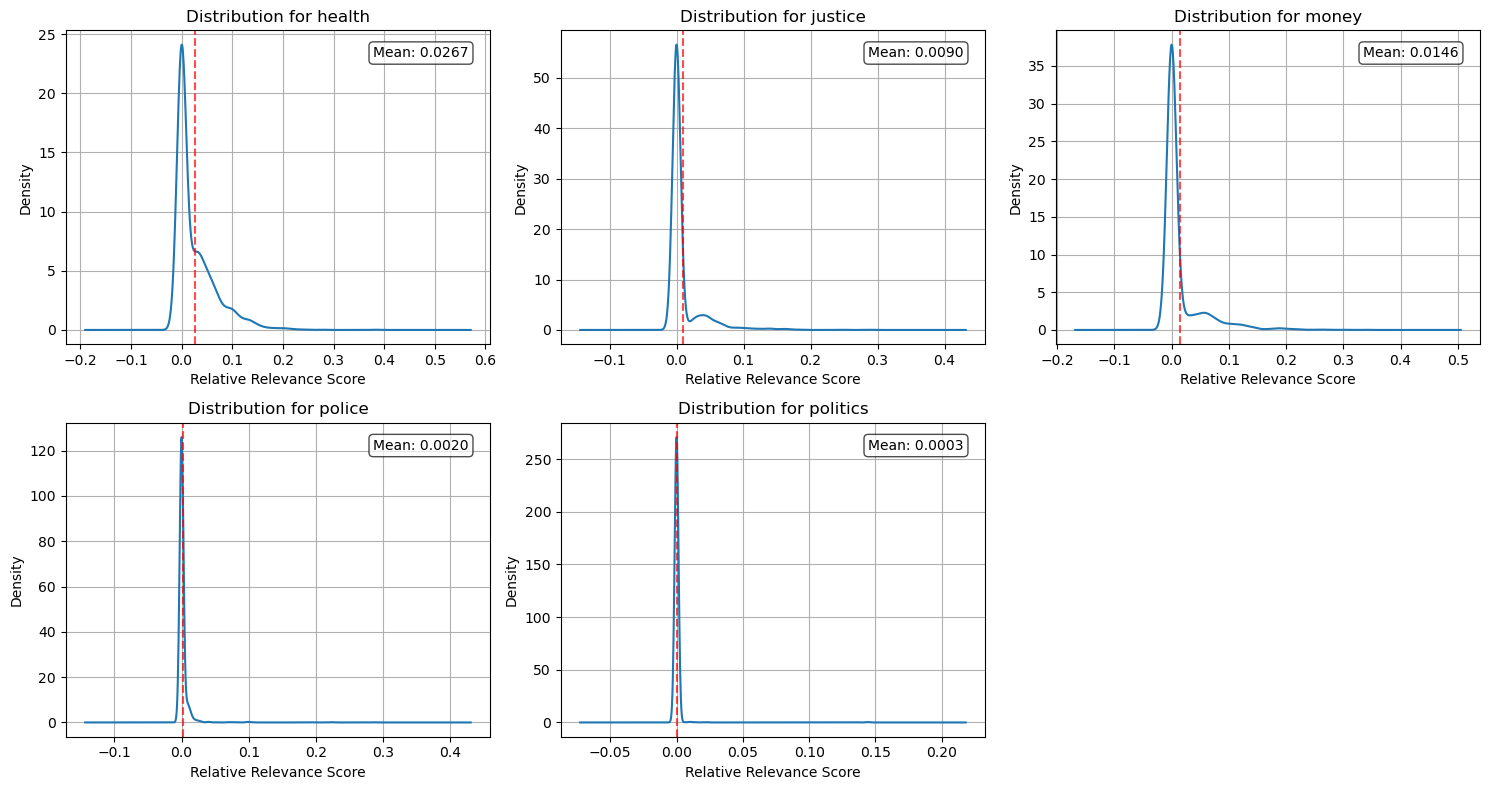

In [103]:
# Get only the columns with relative relevance scores
relevance_cols = [col for col in df_ext.columns if col.startswith('relative_relevance_')]

# Calculate how many subfigures we need
n_topics = len(relevance_cols)
n_cols = 3  # Number of columns in the subplot grid
n_rows = math.ceil(n_topics / n_cols)  # Calculate required number of rows

# Create the figure and subfigures
plt.figure(figsize=(15, n_rows * 4))

# Plot each topic's distribution
for i, col in enumerate(relevance_cols):

    # Create subplot
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Extract clean topic name for the title
    topic_name = col.replace('relative_relevance_', '').replace('terms_', '')

    df_ext[col].plot.kde(
        bw_method='silverman', grid = True)

    # Add a vertical line at the mean
    plt.axvline(df_ext[col].mean(), color='red', linestyle='--', alpha=0.7)
    
    # Set title and labels
    plt.title(f'Distribution for {topic_name}')
    plt.xlabel('Relative Relevance Score')
    plt.ylabel('Density')
    
    # Add the mean value as text
    plt.text(0.95, 0.95, f'Mean: {df_ext[col].mean():.4f}', 
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Adjust layout
plt.tight_layout()
plt.savefig('figures/topic_loadings_distribution_all_songs.png', dpi = 400)
plt.show()

Overall, we can observe that most of the songs (documents) do not explicitly mention at all terms related with our input topics (health, justice, money, police and politics). That is especially true for the topics of "police" and "politics". On the other hand, words related to "health", "justice" and "money" are mentioned a bit more frequently in the songs corpus. Nevertheless, **this does not ensure that the songs' content is actually about a certain topic**, it just means that some songs explicitly mention the input words.

### Only with the songs tagged as "USA"

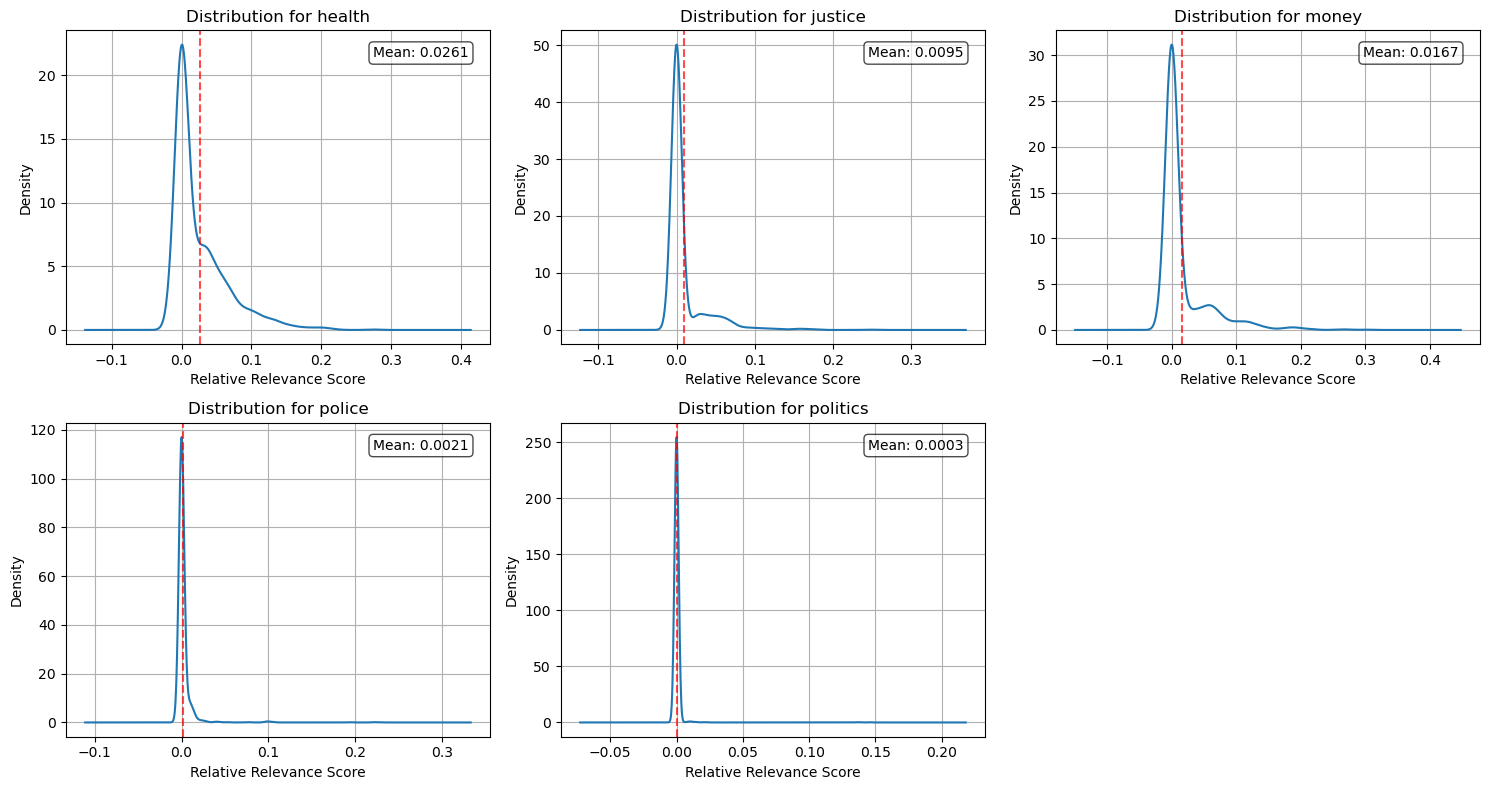

In [104]:
# Get only the columns with relative relevance scores
relevance_cols = [col for col in df_ext.columns if col.startswith('relative_relevance_')]

# Calculate how many subfigures we need
n_topics = len(relevance_cols)
n_cols = 3  # Number of columns in the subplot grid
n_rows = math.ceil(n_topics / n_cols)  # Calculate required number of rows

# Create the figure and subfigures
plt.figure(figsize=(15, n_rows * 4))

# Plot each topic's distribution
for i, col in enumerate(relevance_cols):

    # Create subplot
    plt.subplot(n_rows, n_cols, i + 1)
    
    # Extract clean topic name for the title
    topic_name = col.replace('relative_relevance_', '').replace('terms_', '')

    df_ext[df_ext['USA'] == 1][col].plot.kde(
        bw_method='silverman', grid = True)

    # Add a vertical line at the mean
    plt.axvline(df_ext[df_ext['USA'] == 1][col].mean(), color='red', linestyle='--', alpha=0.7)
    
    # Set title and labels
    plt.title(f'Distribution for {topic_name}')
    plt.xlabel('Relative Relevance Score')
    plt.ylabel('Density')
    
    # Add the mean value as text
    plt.text(0.95, 0.95, f'Mean: {df_ext[df_ext['USA'] == 1][col].mean():.4f}', 
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Adjust layout
plt.tight_layout()
plt.savefig('figures/topic_loadings_distribution_usa_songs.png', dpi = 300)
plt.show()

## Time series of Google Trends data

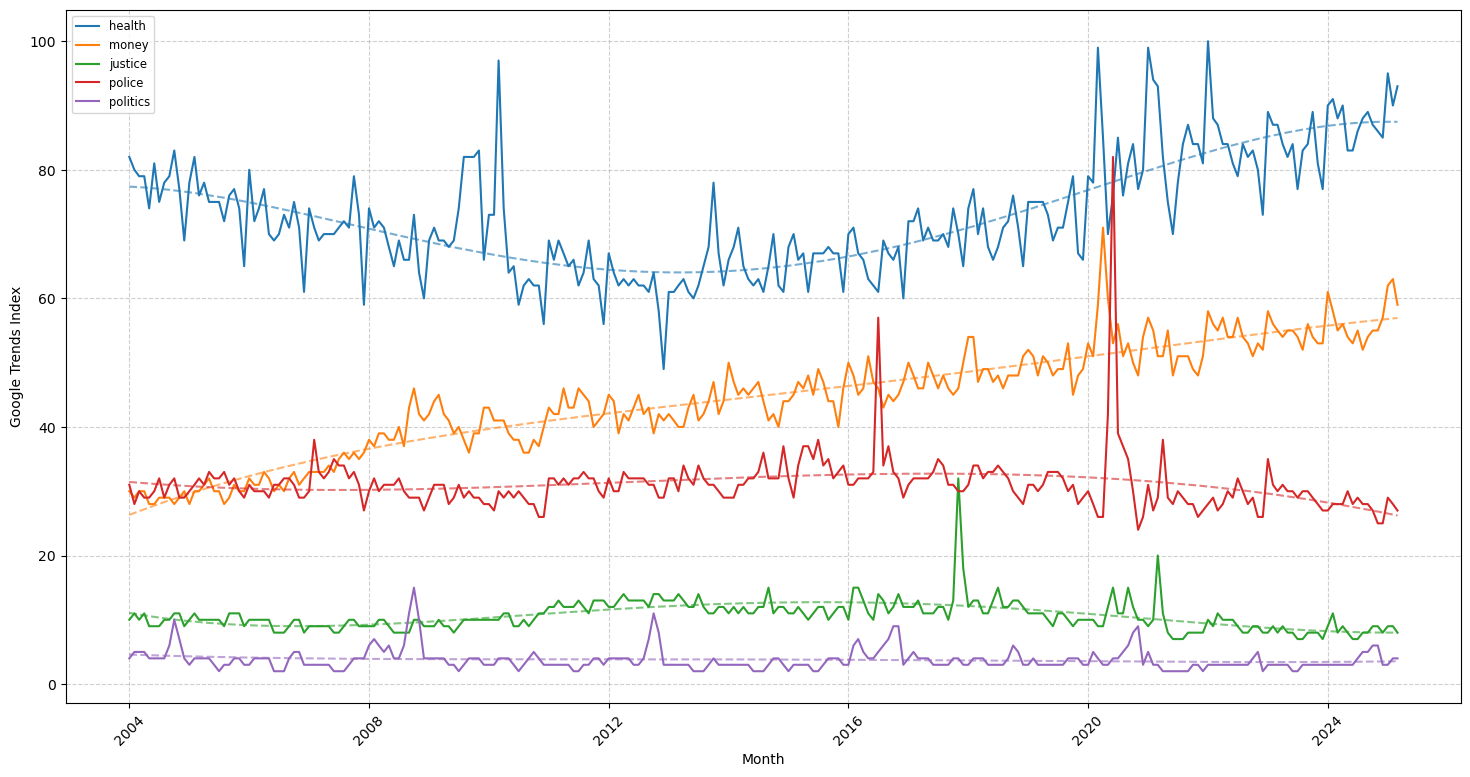

In [105]:
plt.figure(figsize=(18, 9))  # Adjust figure size

for column in df_gt.columns[1:]:
    # Plot the original data
    line, = plt.plot(df_gt['Month'], df_gt[column], label=column)
    
    # Fit a quartic trend line
    x = np.arange(len(df_gt['Month']))
    y = df_gt[column].values
    coeffs = np.polyfit(x, y, 4)
    trend = np.polyval(coeffs, x)
    
    # Plot the quartic trend line with the same color as the line
    plt.plot(df_gt['Month'], trend, linestyle='--', color=line.get_color(), label=None, alpha = 0.6)

plt.xlabel("Month")
plt.ylabel("Google Trends Index")
plt.legend(loc="best", fontsize='small')  # Add legend only for original data
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True, linestyle='--', alpha=0.6)  # Add a light grid
plt.savefig('figures/google_trends.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## Time series of topic loadings and Google Trends data per release month-year

### With all of the songs

In [106]:
# Get only the columns with relative relevance scores
relevance_cols = [col for col in df_ext.columns if col.startswith('relative_relevance_')]

# Now, we group results of df_ext by release year and month
df_ext_subset = df_ext[['release_year_month'] + relevance_cols]
df_grouped = df_ext_subset.groupby('release_year_month').mean().reset_index()

# Convert the release year and month to datetime
df_grouped['release_year_month'] = pd.to_datetime(df_grouped['release_year_month'])

# Reorder it to match the order in Google Trends data
df_grouped = df_grouped[['release_year_month', 'relative_relevance_health', 'relative_relevance_money', 
                         'relative_relevance_justice', 'relative_relevance_police', 'relative_relevance_politics']]

df_grouped = df_grouped.rename(columns = {'release_year_month': 'Month'})

df_grouped.head()

Month  relative_relevance_health  relative_relevance_money  \
0 2003-02-01                   0.040572                  0.000000   
1 2003-03-01                   0.000000                  0.000000   
2 2003-06-01                   0.000000                  0.008137   
3 2003-07-01                   0.009288                  0.006643   
4 2003-08-01                   0.015498                  0.033819   

   relative_relevance_justice  relative_relevance_police  \
0                    0.023197                   0.004915   
1                    0.043855                   0.040851   
2                    0.000000                   0.000000   
3                    0.000000                   0.000000   
4                    0.013493                   0.000000   

   relative_relevance_politics  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          0.0

In [107]:
def plot_dual_axis(df_primary, df_secondary, topics, secondaries, title_file, x_col='Month'):
    """
    Plots subplots with dual y-axes for each topic and its corresponding secondary data.

    Parameters:
    - df_primary: DataFrame containing the primary data.
    - df_secondary: DataFrame containing the secondary data.
    - topics: List of column names for primary y-axis data.
    - secondaries: List of column names for secondary y-axis data.
    - x_col: Column name for x-axis data (default is 'Month').
    """
    num_plots = len(topics)
    fig, axes = plt.subplots(num_plots, 1, figsize=(20, 3 * num_plots), sharex=True)

    if num_plots == 1:
        axes = [axes]

    colors = plt.cm.tab10.colors  # Color palette

    for i, (topic, secondary) in enumerate(zip(topics, secondaries)):
        ax1 = axes[i]
        ax2 = ax1.twinx()

        # Plot primary data
        ax1.plot(df_primary[x_col], df_primary[topic], color=colors[i % len(colors)], label=topic, alpha = 1)
        ax1.set_ylabel('Google Trends Index')
        ax1.tick_params(axis='y')

        # Plot secondary data
        ax2.plot(df_secondary[x_col], df_secondary[secondary], color='grey', linestyle='--', label=secondary, alpha = 0.7)
        ax2.set_ylabel('Relative Word Relevance Score')
        ax2.tick_params(axis='y')

        # Title and grid
        ax1.set_title(f'{topic}')
        ax1.grid(True, linestyle='--', alpha=0.6)

        # Rotate x-axis labels for readability
        ax1.tick_params(axis='x', rotation=45)

        plt.legend(loc = 'upper right')

    plt.xlabel(x_col)
    plt.tight_layout()
    plt.savefig('figures/' + title_file + '.png', dpi = 400, bbox_inches = 'tight')
    plt.show()

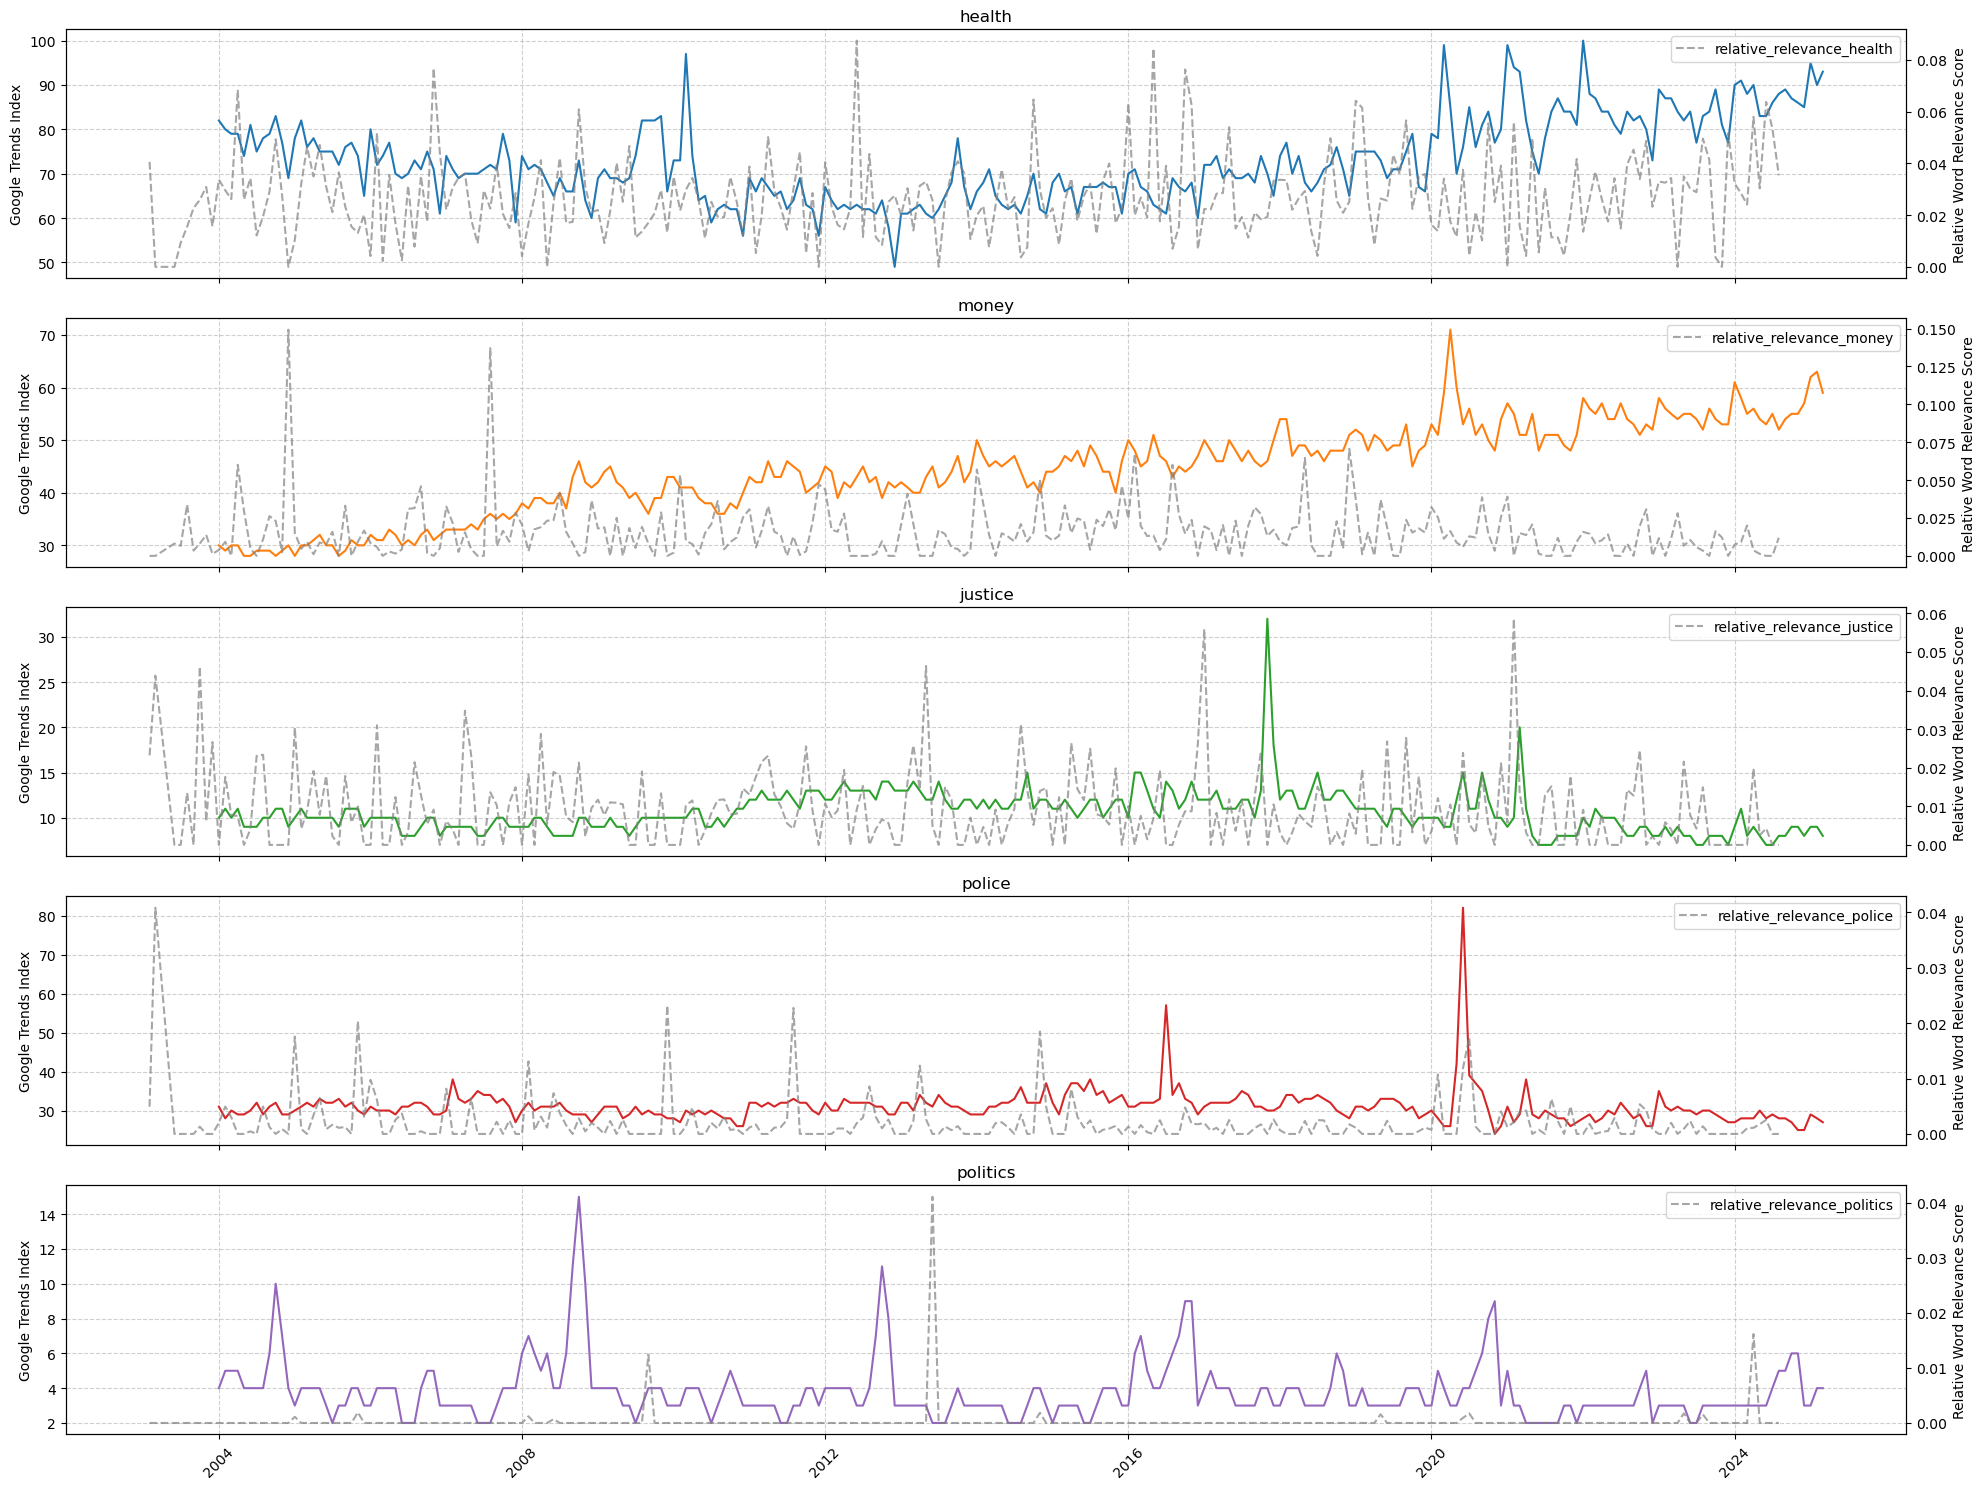

In [108]:
plot_dual_axis(df_gt, df_grouped, df_gt.columns[1:].to_list(), df_grouped.columns[1:].to_list(), title_file = 'topic_loadings_gtrends_all_songs', x_col = 'Month')

All of the topic shares per song seem pure noise, without a clear trend. This probably denotes that:

1. We have just captured words related to topics but that do not reflect the content of the song.
2. Songs' contents on the input topics are relatively constant over time, independent from the interest (or concern) on the topics.

Below we try to graphically analyze the monthly variation of Google Trends data and the topics relevance on the songs.

### Only with the songs tagged as "USA"

In [109]:
# Get only the columns with relative relevance scores
relevance_cols = [col for col in df_ext.columns if col.startswith('relative_relevance_')]

# Get subset of songs tagged as 'USA'
df_ext_usa = df_ext[df_ext['USA'] == 1]

# Now, we group results of df_ext by release year and month
df_ext_subset_usa = df_ext_usa[['release_year_month'] + relevance_cols]
df_grouped_usa = df_ext_subset_usa.groupby('release_year_month').mean().reset_index()

# Convert the release year and month to datetime
df_grouped_usa['release_year_month'] = pd.to_datetime(df_grouped_usa['release_year_month'])

# Reorder it to match the order in Google Trends data
df_grouped_usa = df_grouped_usa[['release_year_month', 'relative_relevance_health', 'relative_relevance_money', 
                         'relative_relevance_justice', 'relative_relevance_police', 'relative_relevance_politics']]

df_grouped_usa = df_grouped_usa.rename(columns = {'release_year_month': 'Month'})

df_grouped_usa.head()

Month  relative_relevance_health  relative_relevance_money  \
0 2003-03-01                   0.000000                  0.000000   
1 2003-06-01                   0.000000                  0.008137   
2 2003-08-01                   0.014228                  0.000000   
3 2003-09-01                   0.030631                  0.002146   
4 2003-10-01                   0.009923                  0.012928   

   relative_relevance_justice  relative_relevance_police  \
0                    0.043855                   0.040851   
1                    0.000000                   0.000000   
2                    0.015999                   0.000000   
3                    0.000000                   0.000000   
4                    0.049236                   0.002096   

   relative_relevance_politics  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          0.0

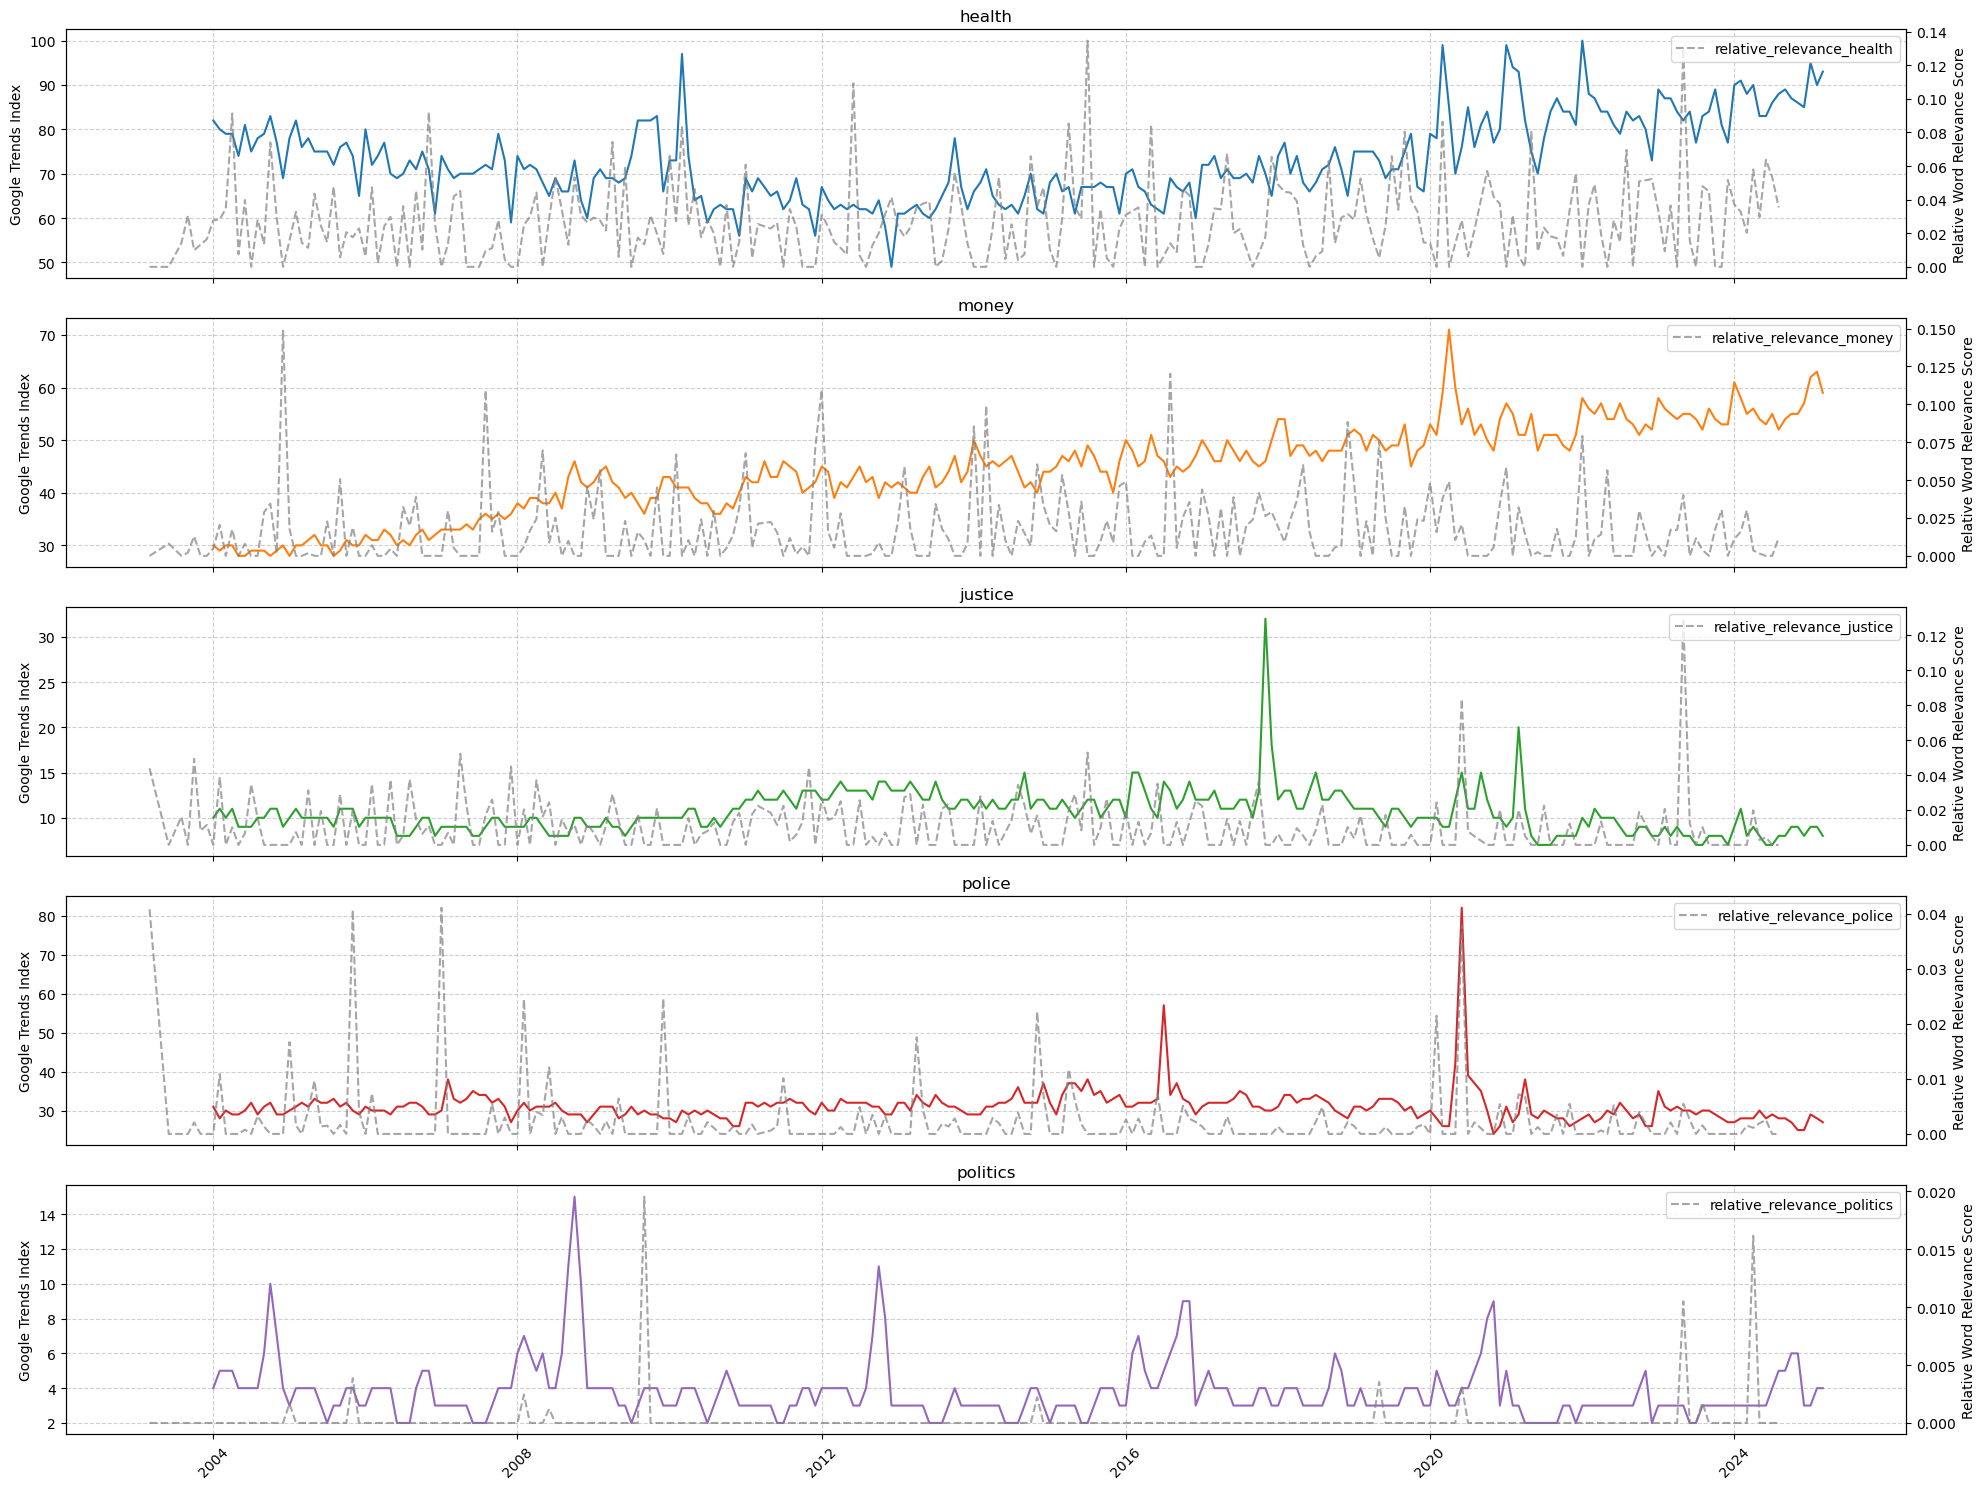

In [110]:
plot_dual_axis(df_gt, df_grouped_usa, df_gt.columns[1:].to_list(), df_grouped_usa.columns[1:].to_list(), title_file = 'topic_loadings_gtrends_usa_songs', x_col = 'Month')

## Time series of the variation of topic loadings and Google Trends data per release month-year (all songs)

In [111]:
# Compute relative variation of Google Trends data
df_gt_relative_variation = df_gt.copy()
# Compute the relative variation of all rows, from column 1 to the last column
df_gt_relative_variation.iloc[:, 1:] = df_gt.iloc[:, 1:].pct_change()

# Display result
df_gt_relative_variation.head()

/tmp/ipykernel_123458/251071274.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0           NaN
1     -0.024390
2     -0.012500
3      0.000000
4     -0.063291
         ...   
250   -0.011494
251   -0.011628
252    0.117647
253   -0.052632
254    0.033333
Name: health, Length: 255, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_gt_relative_variation.iloc[:, 1:] = df_gt.iloc[:, 1:].pct_change()
/tmp/ipykernel_123458/251071274.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0           NaN
1     -0.033333
2      0.034483
3      0.000000
4     -0.066667
         ...   
250    0.000000
251    0.036364
252    0.087719
253    0.016129
254   -0.063492
Name: money, Length: 255, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_

Month    health     money   justice    police  politics
0 2004-01-01       NaN       NaN       NaN       NaN       NaN
1 2004-02-01 -0.024390 -0.033333  0.100000 -0.096774      0.25
2 2004-03-01 -0.012500  0.034483 -0.090909  0.071429      0.00
3 2004-04-01  0.000000  0.000000  0.100000 -0.033333      0.00
4 2004-05-01 -0.063291 -0.066667 -0.181818  0.000000     -0.20

In [112]:
# Compute relative variation of songs data on topic relevance
df_grouped_relative_variation = df_grouped.copy()
# Compute the relative variation of all rows, from column 1 to the last column
df_grouped_relative_variation.iloc[:, 1:] = df_grouped.iloc[:, 1:].pct_change()

# Replace infinite values with NaN
df_grouped_relative_variation.replace([np.inf, -np.inf], np.nan, inplace=True)

# Optionally, fill NaN values with a specific value, such as 0
# df_relative_variation.fillna(0, inplace=True)

# Display result
df_grouped_relative_variation.head()

Month  relative_relevance_health  relative_relevance_money  \
0 2003-02-01                        NaN                       NaN   
1 2003-03-01                  -1.000000                       NaN   
2 2003-06-01                        NaN                       NaN   
3 2003-07-01                        NaN                 -0.183527   
4 2003-08-01                   0.668551                  4.090544   

   relative_relevance_justice  relative_relevance_police  \
0                         NaN                        NaN   
1                    0.890576                    7.31152   
2                   -1.000000                   -1.00000   
3                         NaN                        NaN   
4                         NaN                        NaN   

   relative_relevance_politics  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN

Now, we plot the variations in different subplots (one per topic).

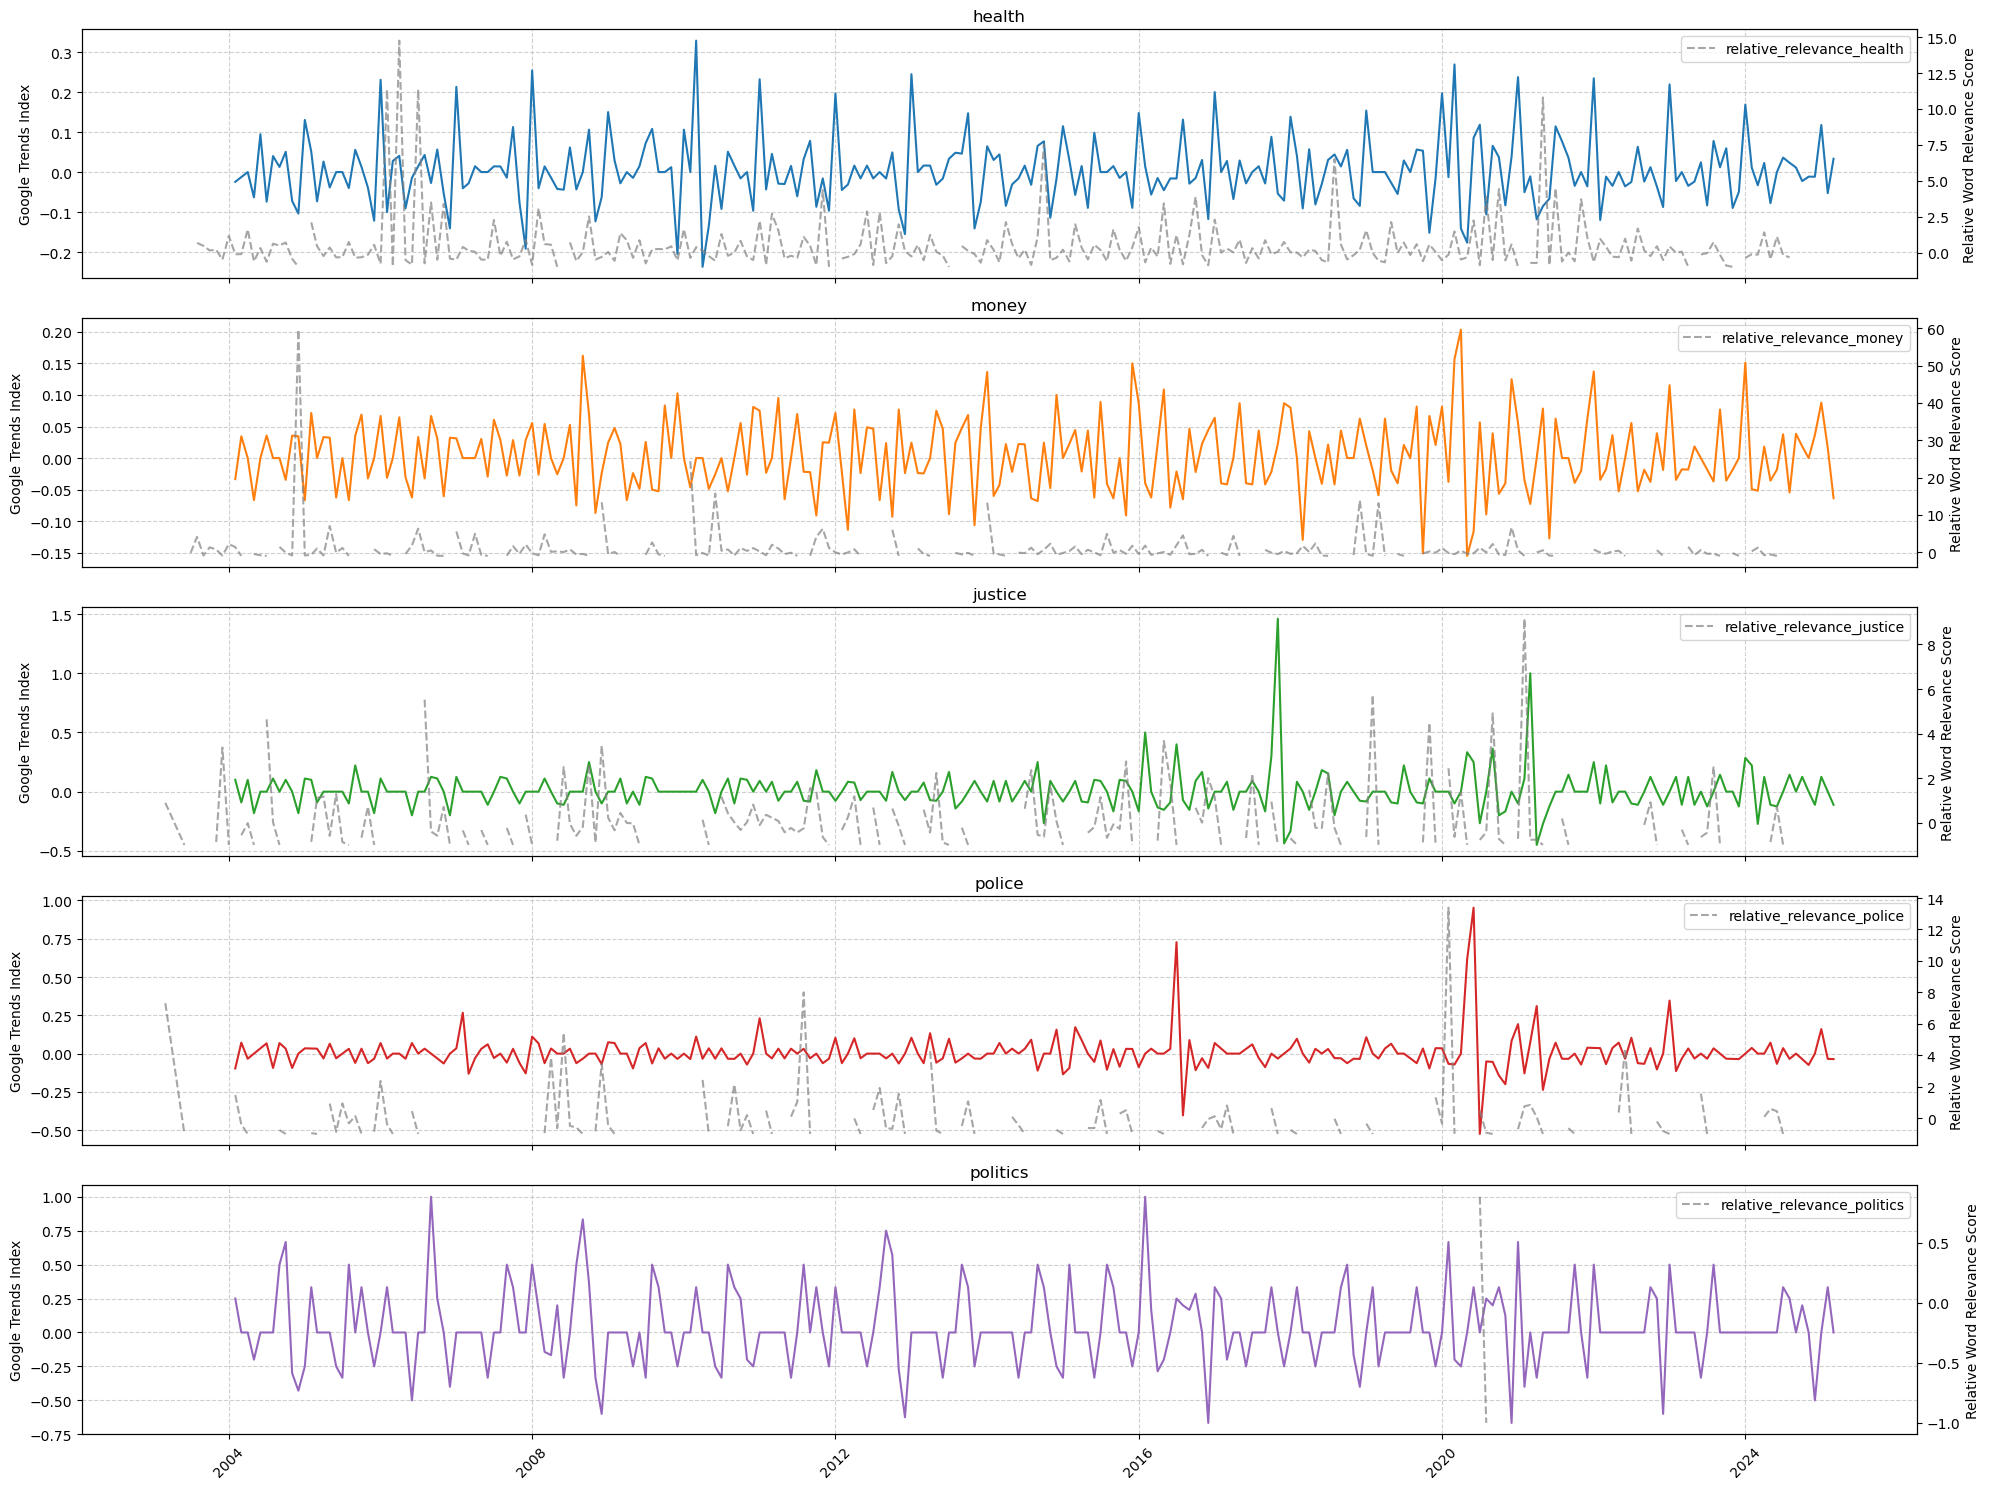

In [116]:
plot_dual_axis(df_gt_relative_variation, df_grouped_relative_variation, df_gt_relative_variation.columns[1:].to_list(), df_grouped_relative_variation.columns[1:].to_list(), title_file = 'variation_all_songs',  x_col = 'Month')

There is no clear, observable pattern. Again, the variations of topic loading (for those topics which have enough loading) seem to be just random noise.

## Wordclouds of songs with highest topic loading

### With all of the songs

In [117]:
dtm_df_ext.head()

ab  able  abused   ac  accent  account  ace  ache  aching  acrobat  ...  \
0  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   
1  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   
2  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   
3  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   
4  0.0   0.0     0.0  0.0     0.0      0.0  0.0   0.0     0.0      0.0  ...   

   zero  zero got  zip  zombie  zone  relative_relevance_health  \
0   0.0       0.0  0.0     0.0   0.0                   0.000000   
1   0.0       0.0  0.0     0.0   0.0                   0.029409   
2   0.0       0.0  0.0     0.0   0.0                   0.098985   
3   0.0       0.0  0.0     0.0   0.0                   0.000000   
4   0.0       0.0  0.0     0.0   0.0                   0.000000   

   relative_relevance_justice  relative_relevance_money  \
0                    0.000000                  0.000000   
1                    0.000000                  0.000000   
2                    0.180572                  0.000000   
3                    0.000000                  0.012878   
4                    0.000000                  0.000000   

   relative_relevance_police  relative_relevance_politics  
0                    0.00000                          0.0  
1                    0.00000                          0.0  
2                    0.03826                          0.0  
3                    0.00000                          0.0  
4                    0.00000                          0.0  

[5 rows x 14011 columns]

In [118]:
# Function to create a word cloud for a specific topic
def create_topic_wordcloud(df, topic_name, title_file, n_top_songs=30):
    # Get the relevance column name for this topic
    relevance_col = f'relative_relevance_{topic_name}'
    
    if relevance_col not in df.columns:
        print(f"Error: Column '{relevance_col}' not found in the DataFrame")
        return
    
    # Sort by the relevance score and get the top n songs
    top_songs_indices = df[relevance_col].nlargest(n_top_songs).index
    
    # Get the subset of the DTM for these songs
    top_songs_dtm = df.loc[top_songs_indices].drop(columns=[col for col in df.columns if col.startswith('relative_relevance_')])
    
    # Calculate term frequencies across these top songs
    term_weights = {}
    for term in top_songs_dtm.columns:
        # Sum the tf-idf weights for this term across all top songs
        weight = top_songs_dtm[term].sum()
        if weight > 0:  # Only include terms that appear in the top songs
            term_weights[term] = weight
    
    # Generate the word cloud
    if term_weights:
        wordcloud = WordCloud(
            width=800, height=400,
            background_color='white',
            max_words=100,
            colormap='viridis',
            collocations=False
        ).generate_from_frequencies(term_weights)
        
        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Topic: {topic_name}')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('figures/' + 'wordcloud_' + topic_name + '_' + title_file + '.png', dpi = 300, bbox_inches = 'tight')
        plt.show()
    else:
        print(f"No terms found for topic {topic_name}")

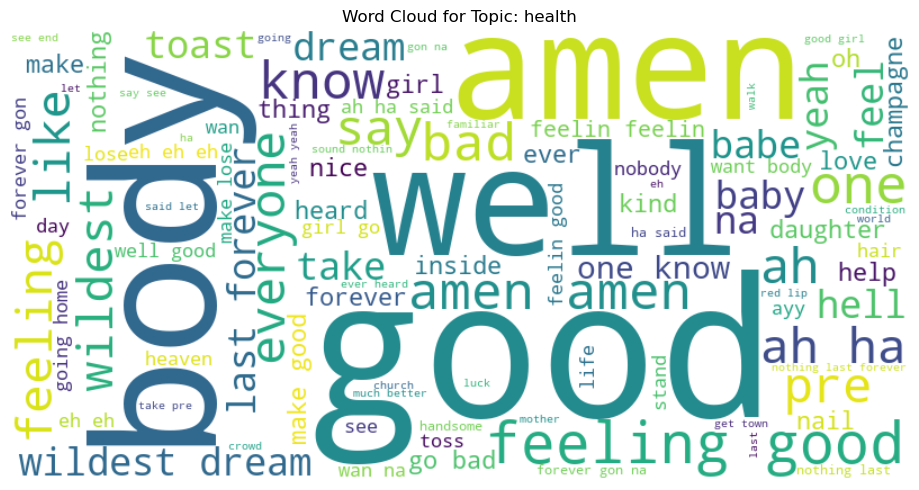

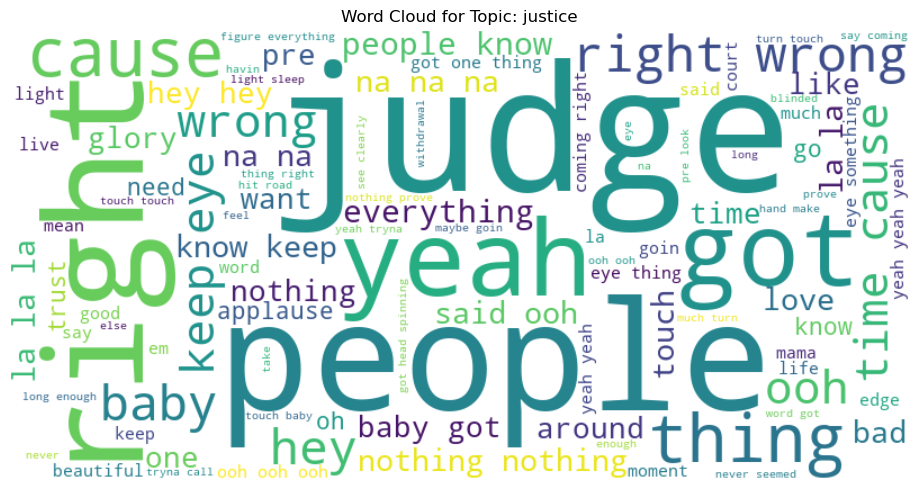

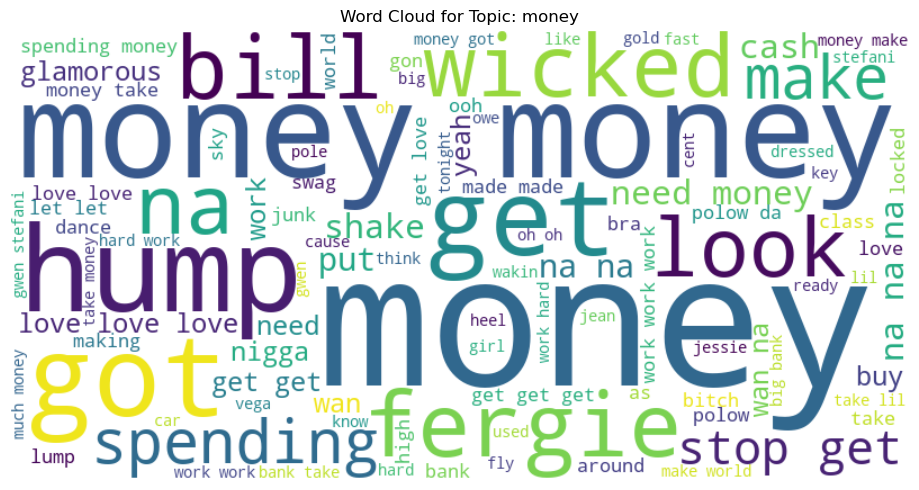

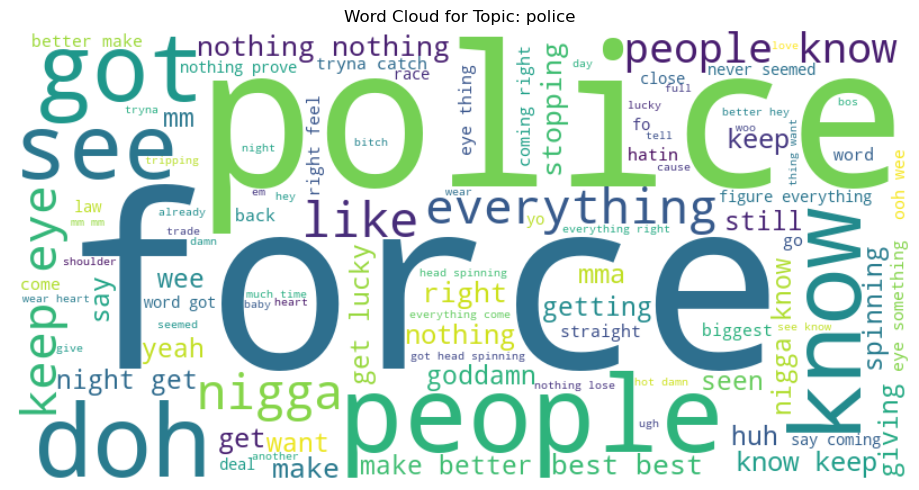

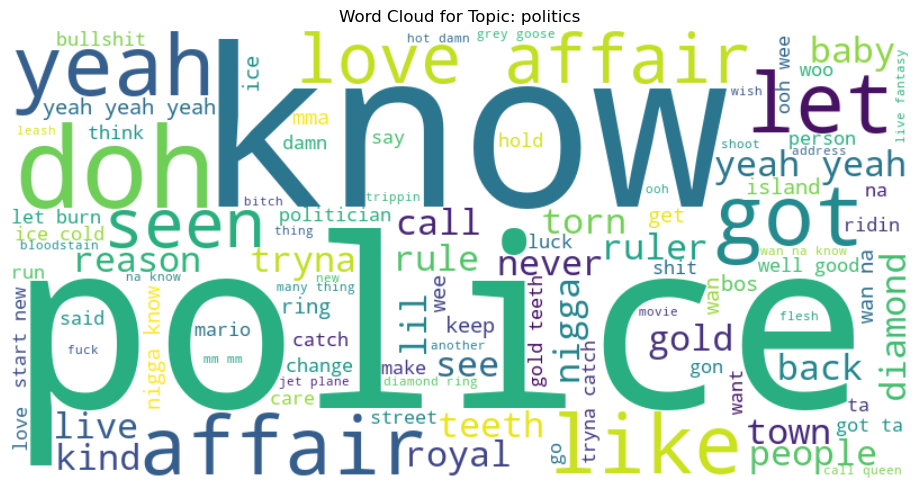

In [119]:
# Get a list of topics from the columns
topics = [col.replace('relative_relevance_', '') for col in dtm_df_ext.columns if col.startswith('relative_relevance_')]

# Create a word cloud for each topic
for topic in topics:
    create_topic_wordcloud(dtm_df_ext, topic, title_file = 'all_songs', n_top_songs=20)

### Only with the songs tagged as "USA"

In [120]:
# We get the index of those songs tagged as "USA"
# Filter the DataFrame for songs tagged as 'USA'
df_ext_usa = df_ext[df_ext['USA'] == 1]

# Get the indices of the filtered songs
indices_usa = df_ext_usa.index

# Keep only the rows corresponding to the indices of songs tagged as 'USA'
dtm_df_ext_usa = dtm_df_ext.loc[dtm_df_ext.index.isin(indices_usa)]

print(f'Does the number of rows of the filtered DTM match the number of songs tagged as "USA"? {dtm_df_ext_usa.shape[0] == len(indices_usa)}')

Does the number of rows of the filtered DTM match the number of songs tagged as "USA"? True


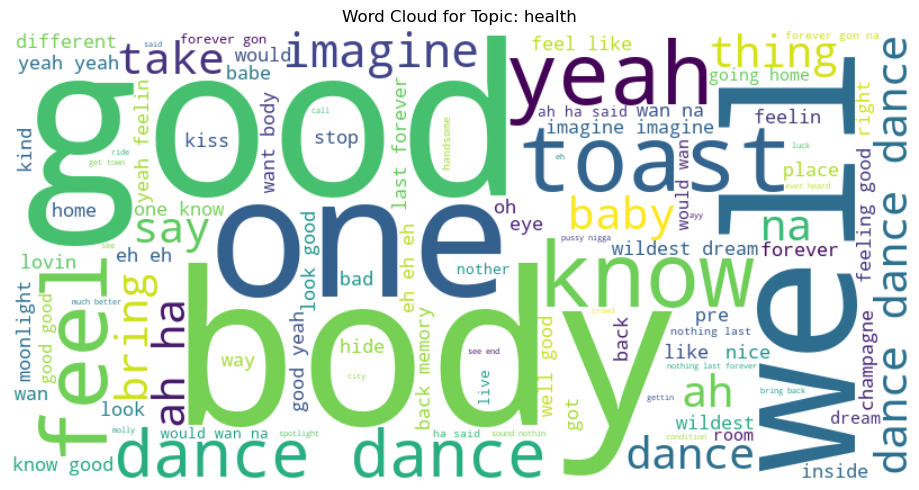

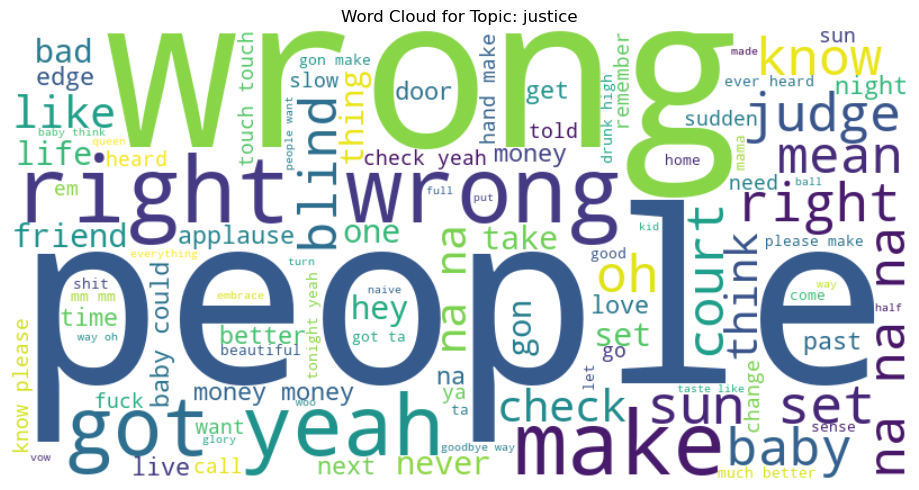

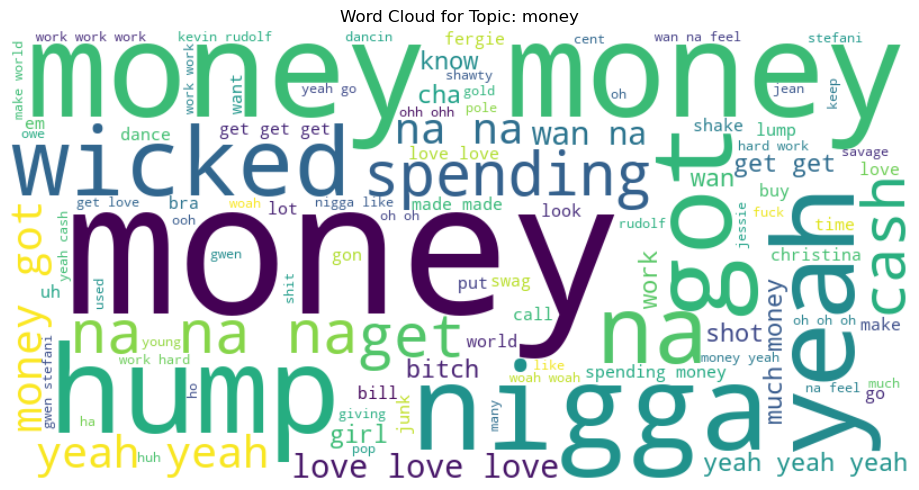

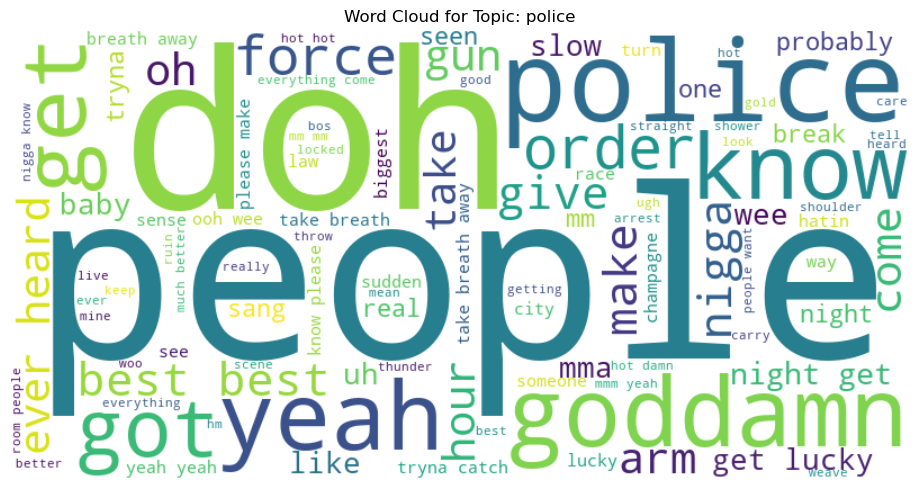

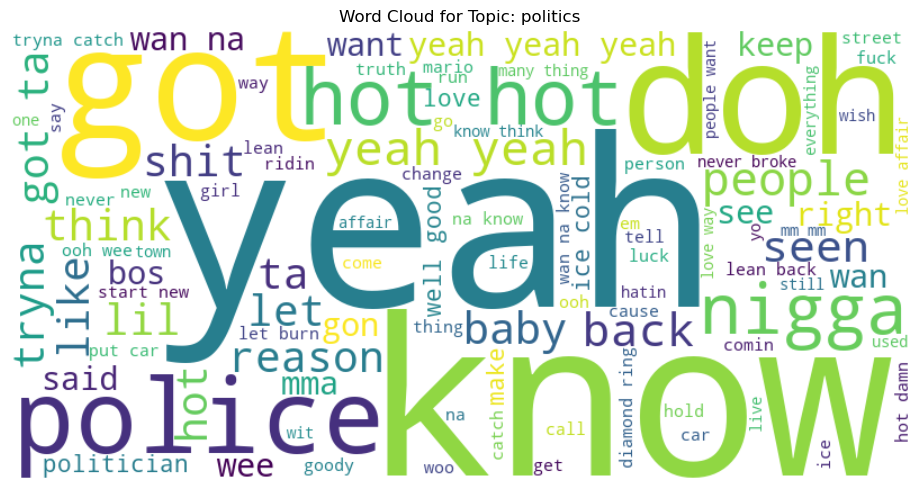

In [121]:
# Get a list of topics from the columns
topics = [col.replace('relative_relevance_', '') for col in dtm_df_ext_usa.columns if col.startswith('relative_relevance_')]

# Create a word cloud for each topic
for topic in topics:
    create_topic_wordcloud(dtm_df_ext_usa, topic, title_file = 'usa_songs', n_top_songs=20)